In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
!wget -P . http://www.atarimania.com/roms/Roms.rar
!unrar e ./Roms.rar
!unzip ROMS.zip
!python -m atari_py.import_roms ./ROMS

In [ ]:
def plot_learning_curve(x, scores, epsilons, lines=None):
    plt.ion()
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)
    plt.show()

In [ ]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [ ]:
class RepeatActionAndMaxFrame(gym.Wrapper):
    def __init__(self, env=None, repeat=4, clip_reward=False, no_ops=0,
                 fire_first=False):
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        self.frame_buffer = np.zeros_like((2, self.shape))
        self.clip_reward = clip_reward
        self.no_ops = no_ops
        self.fire_first = fire_first

    def step(self, action):
        t_reward = 0.0
        done = False
        for i in range(self.repeat):
            obs, reward, done, info = self.env.step(action)
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]
            t_reward += reward
            idx = i % 2
            self.frame_buffer[idx] = obs
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        return max_frame, t_reward, done, info

    def reset(self):
        obs = self.env.reset()
        no_ops = np.random.randint(self.no_ops)+1 if self.no_ops > 0 else 0
        for _ in range(no_ops):
            _, _, done, _ = self.env.step(0)
            if done:
                self.env.reset()
        if self.fire_first:
            assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
            obs, _, _, _ = self.env.step(1)

        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = obs

        return obs

In [ ]:
class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, shape, env=None):
        super(PreprocessFrame, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                    shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0

        return new_obs

In [ ]:
class StackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                            env.observation_space.low.repeat(repeat, axis=0),
                            env.observation_space.high.repeat(repeat, axis=0),
                            dtype=np.float32)
        self.stack = deque(maxlen=repeat)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

In [ ]:
def make_env(env_name, shape=(84,84,1), repeat=4, clip_rewards=False,
             no_ops=0, fire_first=False):
    env = gym.make(env_name)
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first)
    env = PreprocessFrame(shape, env)
    env = StackFrames(env, repeat)

    return env

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()
        self.checkpoint_file = os.path.join(chkpt_dir, name)

        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = torch.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        # conv3 shape is BS x n_filters x H x W
        conv_state = conv3.view(conv3.size()[0], -1)
        # conv_state shape is BS x (n_filters * H * W)
        flat1 = F.relu(self.fc1(conv_state))
        actions = self.fc2(flat1)

        return actions

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

In [ ]:
class DDQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir)

        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = torch.tensor([observation],dtype=torch.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = torch.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = torch.tensor(state).to(self.q_eval.device)
        rewards = torch.tensor(reward).to(self.q_eval.device)
        dones = torch.tensor(done).to(self.q_eval.device)
        actions = torch.tensor(action).to(self.q_eval.device)
        states_ = torch.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_)
        q_eval = self.q_eval.forward(states_)

        max_actions = torch.argmax(q_eval, dim=1)
        q_next[dones] = 0.0
        
        q_target = rewards + self.gamma*q_next[indices, max_actions]

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


episode:  0 score:  -21.0  average score -21.0 best score -inf epsilon 0.99 steps 1063
... saving checkpoint ...
... saving checkpoint ...


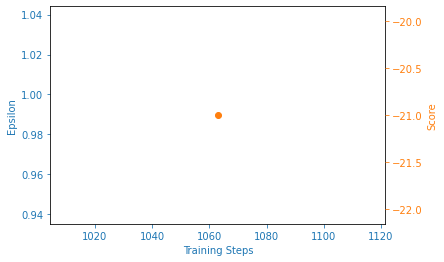

episode:  1 score:  -21.0  average score -21.0 best score -21.00 epsilon 0.98 steps 1887


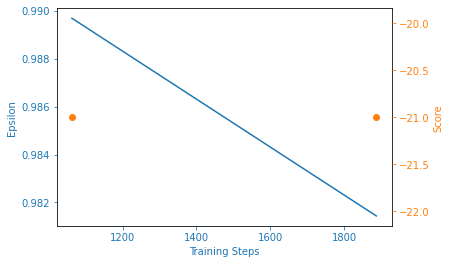

episode:  2 score:  -21.0  average score -21.0 best score -21.00 epsilon 0.97 steps 2818


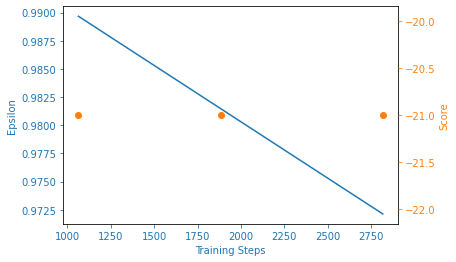

episode:  3 score:  -19.0  average score -20.5 best score -21.00 epsilon 0.96 steps 3832
... saving checkpoint ...
... saving checkpoint ...


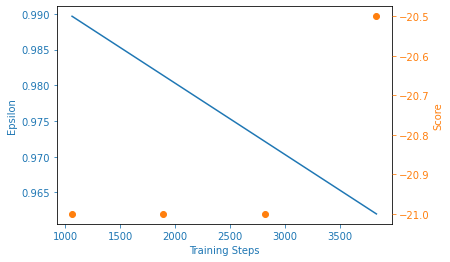

episode:  4 score:  -21.0  average score -20.6 best score -20.50 epsilon 0.95 steps 4624


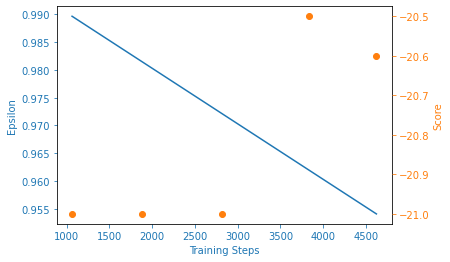

episode:  5 score:  -21.0  average score -20.7 best score -20.50 epsilon 0.95 steps 5388


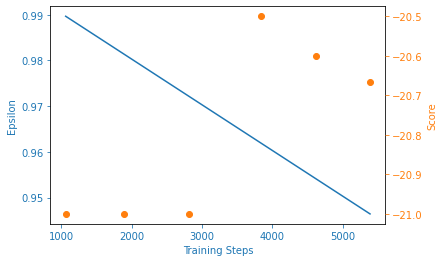

episode:  6 score:  -21.0  average score -20.7 best score -20.50 epsilon 0.94 steps 6300


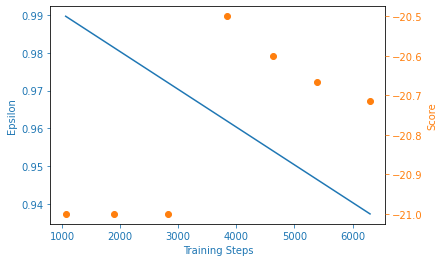

episode:  7 score:  -19.0  average score -20.5 best score -20.50 epsilon 0.93 steps 7335


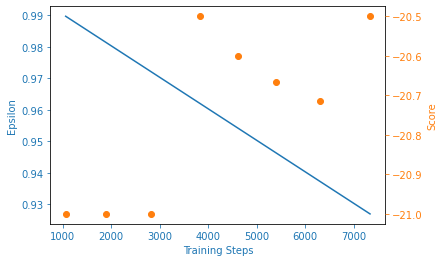

episode:  8 score:  -19.0  average score -20.3 best score -20.50 epsilon 0.91 steps 8537
... saving checkpoint ...
... saving checkpoint ...


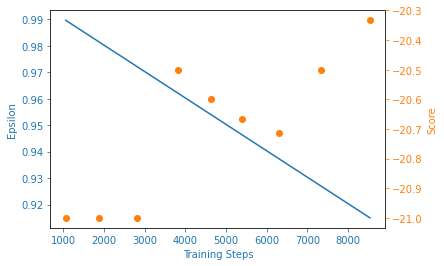

episode:  9 score:  -18.0  average score -20.1 best score -20.33 epsilon 0.90 steps 9593
... saving checkpoint ...
... saving checkpoint ...


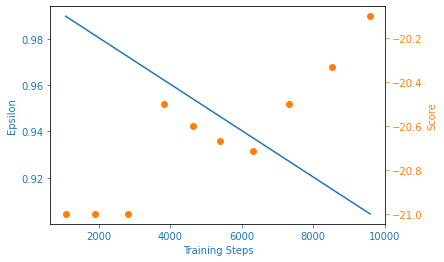

episode:  10 score:  -20.0  average score -20.1 best score -20.10 epsilon 0.89 steps 10542
... saving checkpoint ...
... saving checkpoint ...


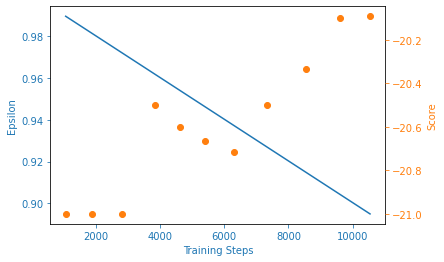

episode:  11 score:  -20.0  average score -20.1 best score -20.09 epsilon 0.89 steps 11464
... saving checkpoint ...
... saving checkpoint ...


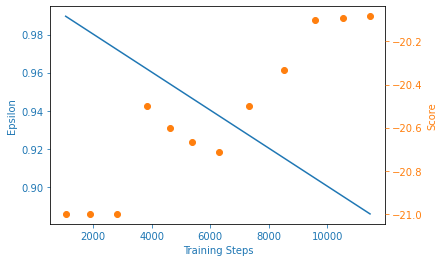

episode:  12 score:  -20.0  average score -20.1 best score -20.08 epsilon 0.88 steps 12410
... saving checkpoint ...
... saving checkpoint ...


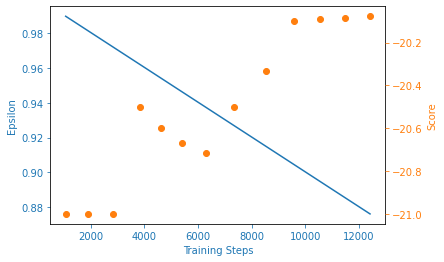

episode:  13 score:  -20.0  average score -20.1 best score -20.08 epsilon 0.87 steps 13528
... saving checkpoint ...
... saving checkpoint ...


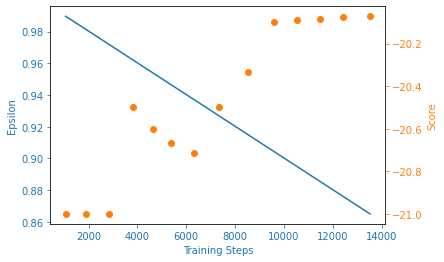

episode:  14 score:  -21.0  average score -20.1 best score -20.07 epsilon 0.86 steps 14431


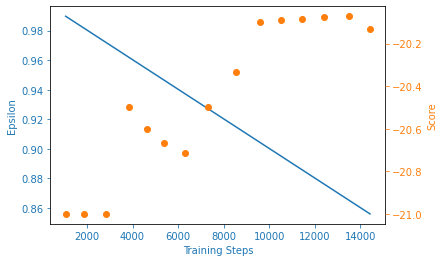

episode:  15 score:  -21.0  average score -20.2 best score -20.07 epsilon 0.85 steps 15374


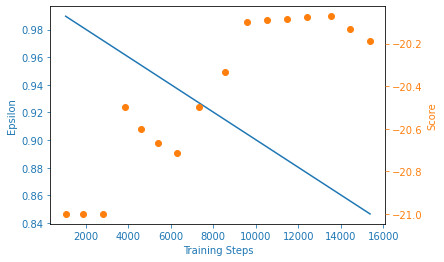

episode:  16 score:  -21.0  average score -20.2 best score -20.07 epsilon 0.84 steps 16204


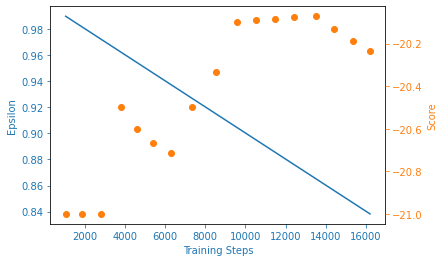

episode:  17 score:  -21.0  average score -20.3 best score -20.07 epsilon 0.83 steps 17117


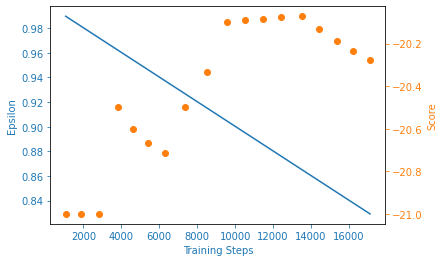

episode:  18 score:  -21.0  average score -20.3 best score -20.07 epsilon 0.82 steps 17972


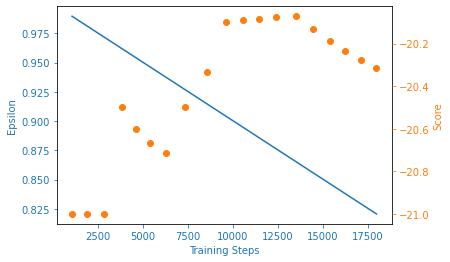

episode:  19 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.81 steps 18982


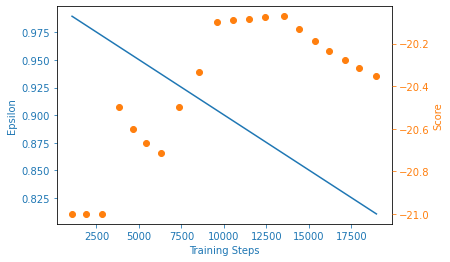

episode:  20 score:  -20.0  average score -20.3 best score -20.07 epsilon 0.80 steps 19879


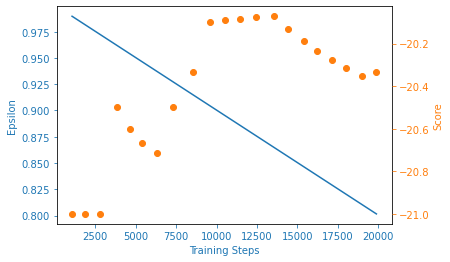

episode:  21 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.79 steps 20699


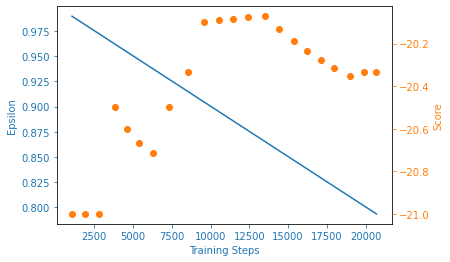

episode:  22 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.79 steps 21491


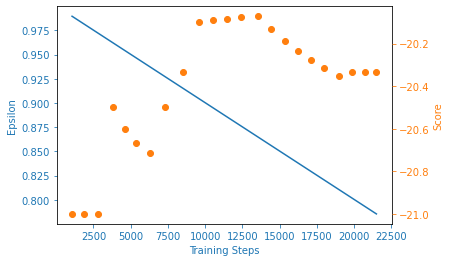

episode:  23 score:  -20.0  average score -20.4 best score -20.07 epsilon 0.78 steps 22517


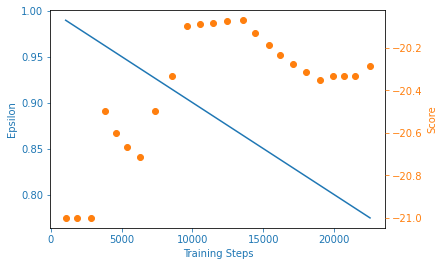

episode:  24 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.76 steps 23536


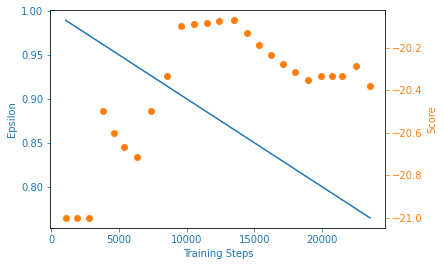

episode:  25 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.76 steps 24439


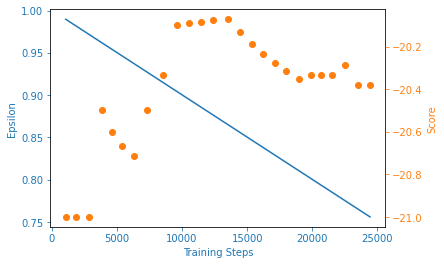

episode:  26 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.75 steps 25312


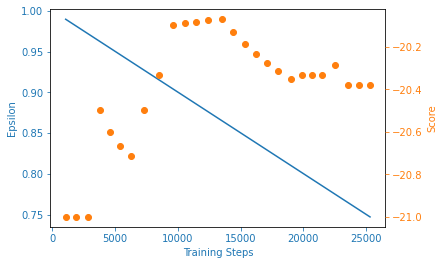

episode:  27 score:  -20.0  average score -20.4 best score -20.07 epsilon 0.74 steps 26252


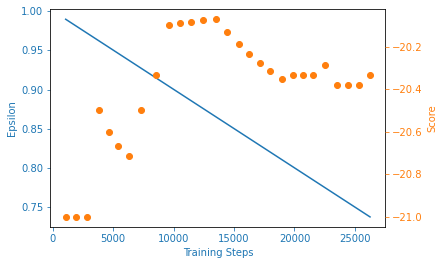

episode:  28 score:  -19.0  average score -20.4 best score -20.07 epsilon 0.73 steps 27202


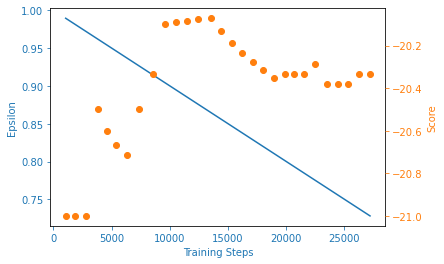

episode:  29 score:  -19.0  average score -20.3 best score -20.07 epsilon 0.72 steps 28151


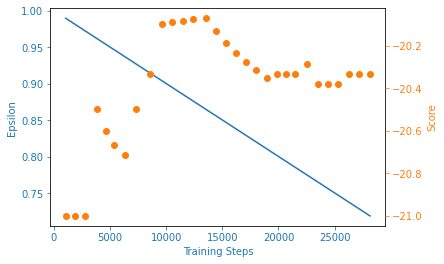

episode:  30 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.71 steps 29111


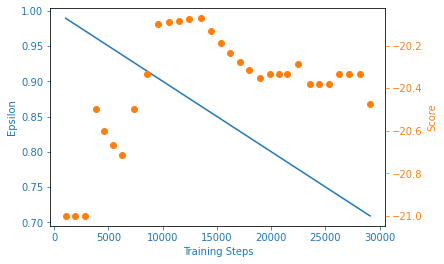

episode:  31 score:  -19.0  average score -20.3 best score -20.07 epsilon 0.70 steps 30328


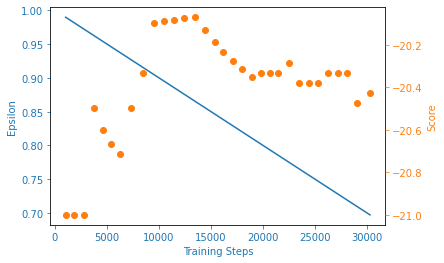

episode:  32 score:  -21.0  average score -20.3 best score -20.07 epsilon 0.69 steps 31294


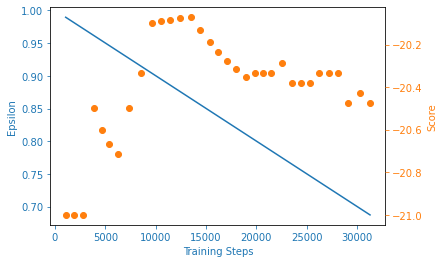

episode:  33 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.68 steps 32176


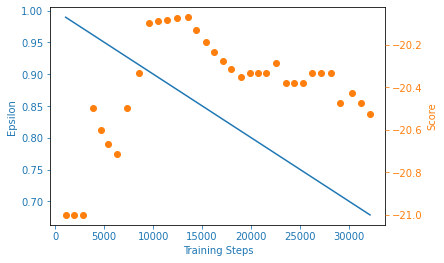

episode:  34 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.67 steps 33196


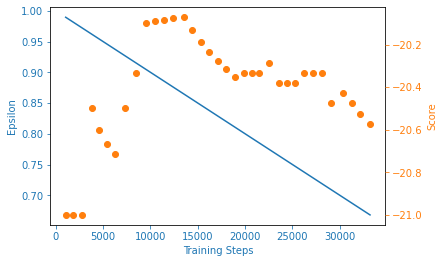

episode:  35 score:  -20.0  average score -20.4 best score -20.07 epsilon 0.66 steps 34191


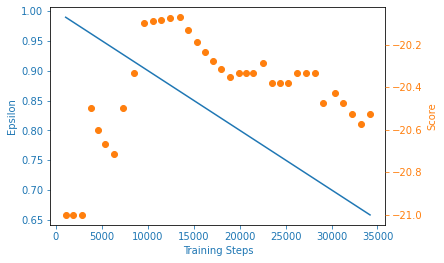

episode:  36 score:  -20.0  average score -20.4 best score -20.07 epsilon 0.65 steps 35406


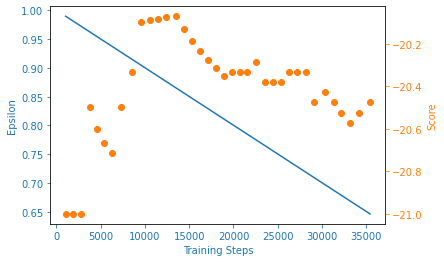

episode:  37 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.63 steps 36642


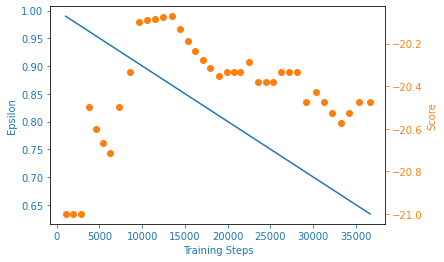

episode:  38 score:  -21.0  average score -20.4 best score -20.07 epsilon 0.62 steps 37897


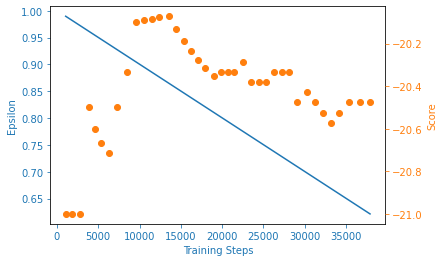

episode:  39 score:  -19.0  average score -20.4 best score -20.07 epsilon 0.61 steps 39097


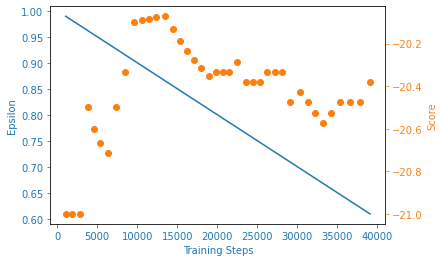

episode:  40 score:  -18.0  average score -20.3 best score -20.07 epsilon 0.59 steps 40597


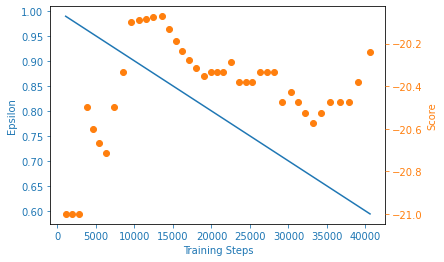

episode:  41 score:  -17.0  average score -20.2 best score -20.07 epsilon 0.58 steps 42190


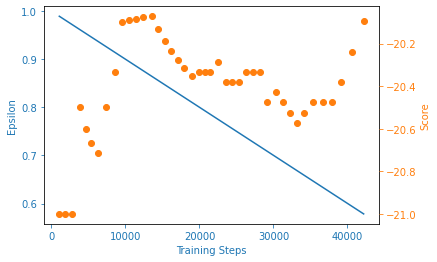

episode:  42 score:  -20.0  average score -20.2 best score -20.07 epsilon 0.56 steps 43595


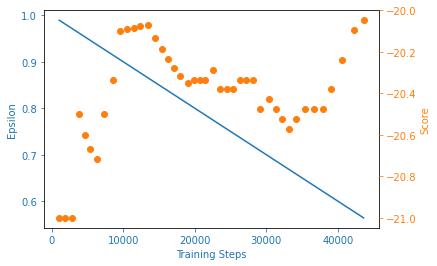

episode:  43 score:  -19.0  average score -20.2 best score -20.07 epsilon 0.55 steps 44780


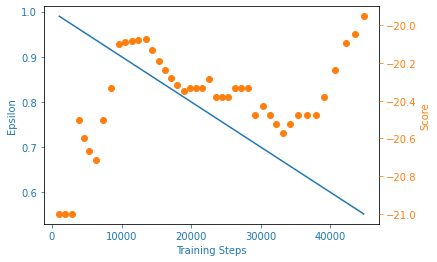

episode:  44 score:  -18.0  average score -20.1 best score -20.07 epsilon 0.54 steps 46162


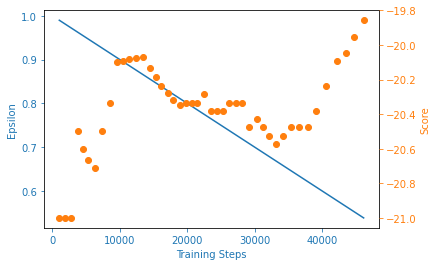

episode:  45 score:  -18.0  average score -20.1 best score -20.07 epsilon 0.52 steps 47585


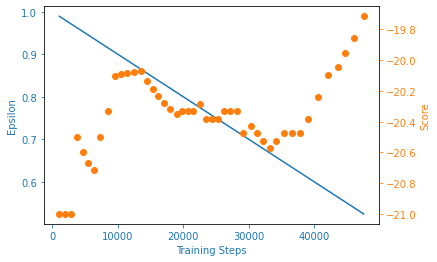

episode:  46 score:  -19.0  average score -20.1 best score -20.07 epsilon 0.51 steps 48996
... saving checkpoint ...
... saving checkpoint ...


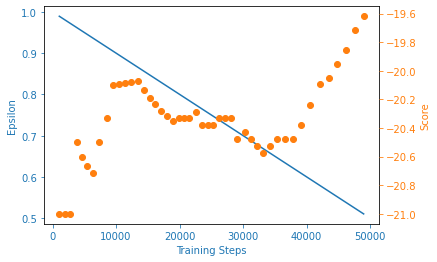

episode:  47 score:  -20.0  average score -20.1 best score -20.06 epsilon 0.50 steps 50103
... saving checkpoint ...
... saving checkpoint ...


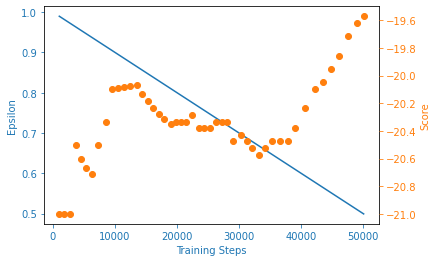

episode:  48 score:  -18.0  average score -20.0 best score -20.06 epsilon 0.49 steps 51478
... saving checkpoint ...
... saving checkpoint ...


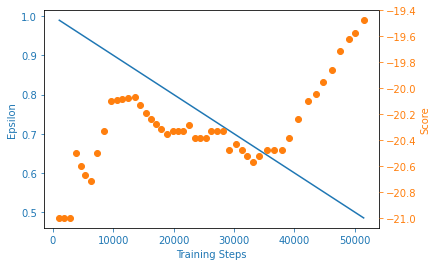

episode:  49 score:  -19.0  average score -20.0 best score -20.02 epsilon 0.47 steps 52844
... saving checkpoint ...
... saving checkpoint ...


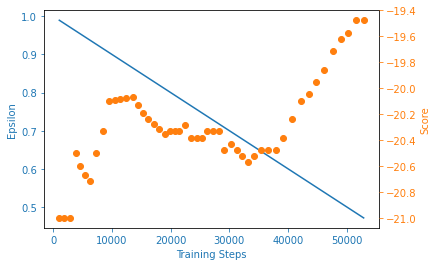

episode:  50 score:  -19.0  average score -20.0 best score -20.00 epsilon 0.46 steps 54283
... saving checkpoint ...
... saving checkpoint ...


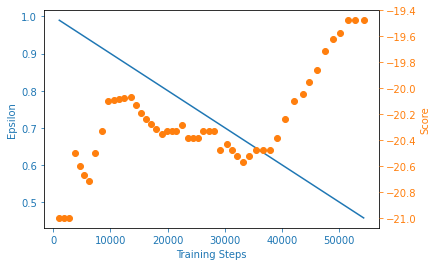

episode:  51 score:  -21.0  average score -20.0 best score -19.98 epsilon 0.44 steps 55606


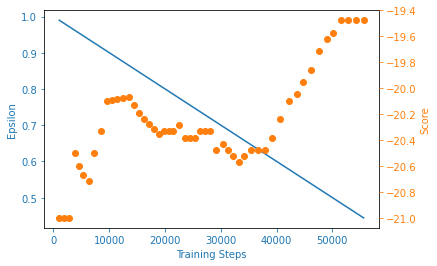

episode:  52 score:  -20.0  average score -20.0 best score -19.98 epsilon 0.43 steps 56703


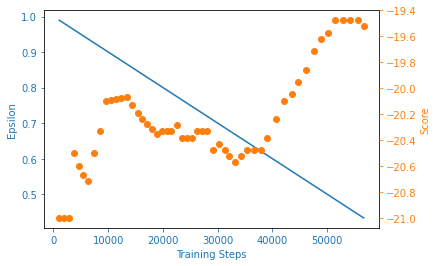

episode:  53 score:  -19.0  average score -20.0 best score -19.98 epsilon 0.42 steps 58188


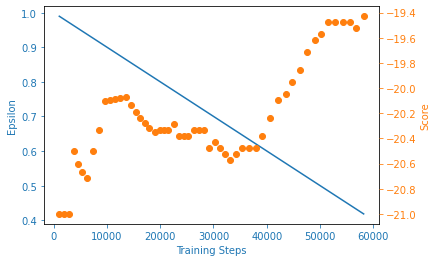

episode:  54 score:  -17.0  average score -19.9 best score -19.98 epsilon 0.40 steps 59719
... saving checkpoint ...
... saving checkpoint ...


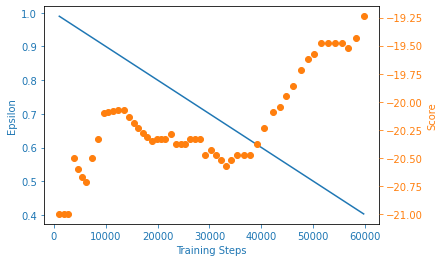

episode:  55 score:  -19.0  average score -19.9 best score -19.93 epsilon 0.39 steps 61159
... saving checkpoint ...
... saving checkpoint ...


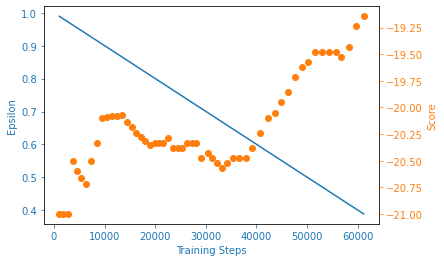

episode:  56 score:  -20.0  average score -19.9 best score -19.91 epsilon 0.38 steps 62529


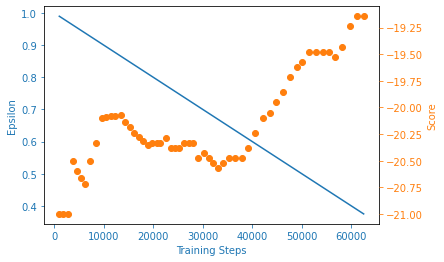

episode:  57 score:  -16.0  average score -19.8 best score -19.91 epsilon 0.36 steps 64530
... saving checkpoint ...
... saving checkpoint ...


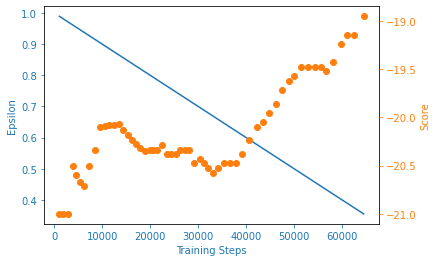

episode:  58 score:  -17.0  average score -19.8 best score -19.84 epsilon 0.34 steps 66091
... saving checkpoint ...
... saving checkpoint ...


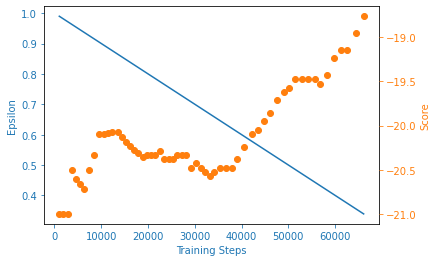

episode:  59 score:  -18.0  average score -19.8 best score -19.80 epsilon 0.32 steps 67541
... saving checkpoint ...
... saving checkpoint ...


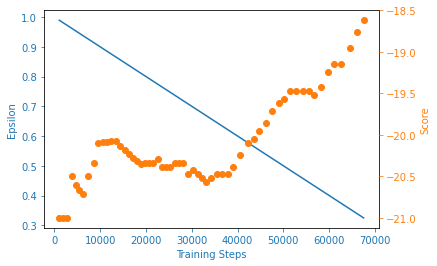

episode:  60 score:  -15.0  average score -19.7 best score -19.77 epsilon 0.30 steps 69709
... saving checkpoint ...
... saving checkpoint ...


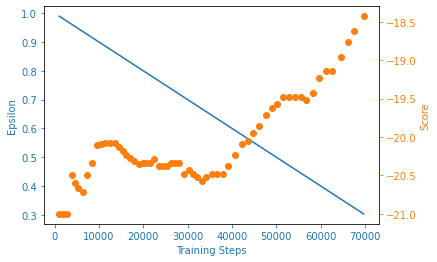

episode:  61 score:  -16.0  average score -19.6 best score -19.69 epsilon 0.28 steps 71659
... saving checkpoint ...
... saving checkpoint ...


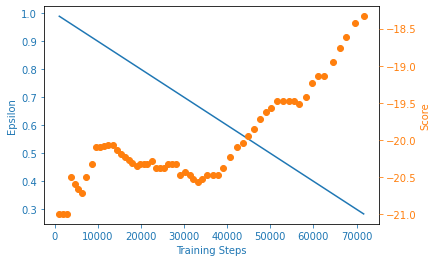

episode:  62 score:  -21.0  average score -19.7 best score -19.63 epsilon 0.27 steps 73123


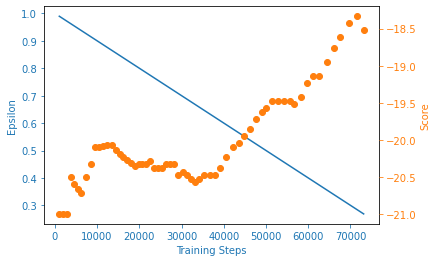

episode:  63 score:  -13.0  average score -19.5 best score -19.63 epsilon 0.24 steps 75551
... saving checkpoint ...
... saving checkpoint ...


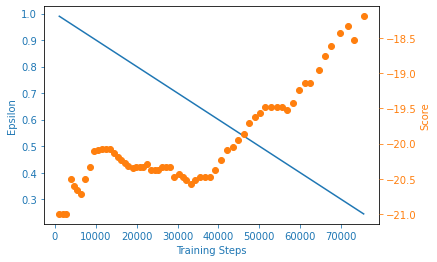

episode:  64 score:  -17.0  average score -19.5 best score -19.55 epsilon 0.23 steps 77481
... saving checkpoint ...
... saving checkpoint ...


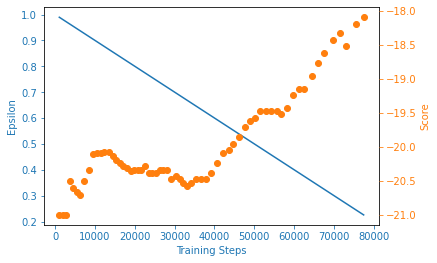

episode:  65 score:  -13.0  average score -19.4 best score -19.51 epsilon 0.20 steps 79608
... saving checkpoint ...
... saving checkpoint ...


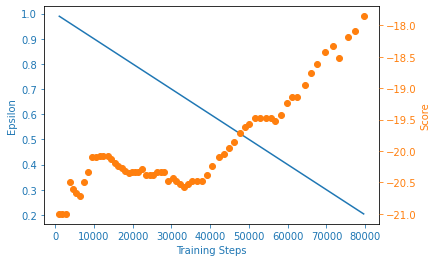

episode:  66 score:  -15.0  average score -19.3 best score -19.41 epsilon 0.18 steps 81662
... saving checkpoint ...
... saving checkpoint ...


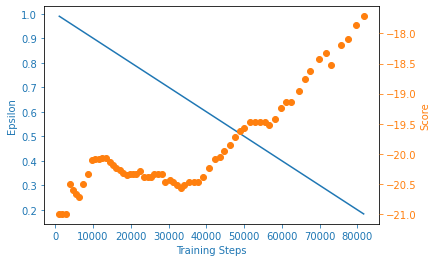

episode:  67 score:  -19.0  average score -19.3 best score -19.34 epsilon 0.17 steps 83429
... saving checkpoint ...
... saving checkpoint ...


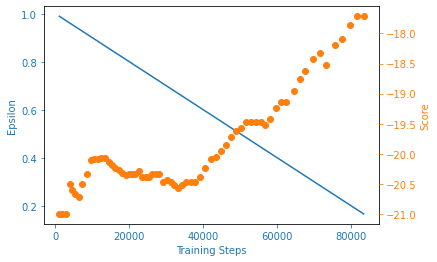

episode:  68 score:  -17.0  average score -19.3 best score -19.34 epsilon 0.15 steps 85397
... saving checkpoint ...
... saving checkpoint ...


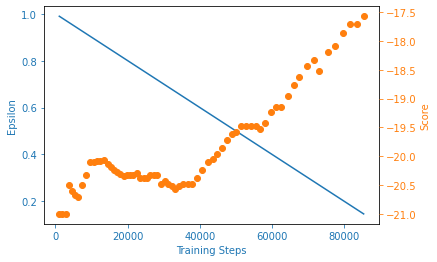

episode:  69 score:  -18.0  average score -19.3 best score -19.30 epsilon 0.13 steps 87098
... saving checkpoint ...
... saving checkpoint ...


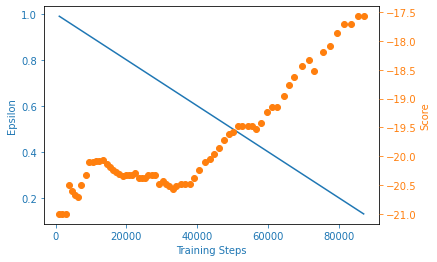

episode:  70 score:  -19.0  average score -19.3 best score -19.29 epsilon 0.11 steps 89186
... saving checkpoint ...
... saving checkpoint ...


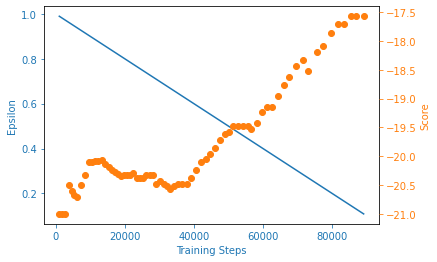

episode:  71 score:  -14.0  average score -19.2 best score -19.28 epsilon 0.10 steps 91722
... saving checkpoint ...
... saving checkpoint ...


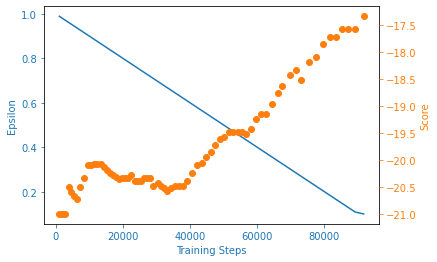

episode:  72 score:  -16.0  average score -19.2 best score -19.21 epsilon 0.10 steps 93749
... saving checkpoint ...
... saving checkpoint ...


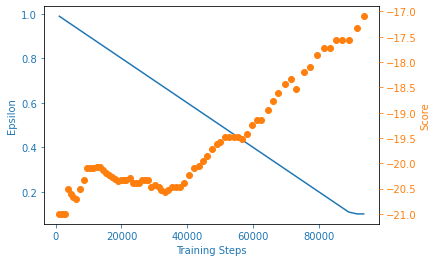

episode:  73 score:  -10.0  average score -19.0 best score -19.16 epsilon 0.10 steps 96479
... saving checkpoint ...
... saving checkpoint ...


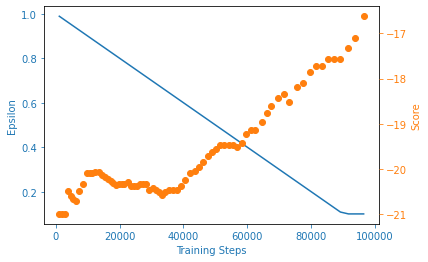

episode:  74 score:  -19.0  average score -19.0 best score -19.04 epsilon 0.10 steps 98376
... saving checkpoint ...
... saving checkpoint ...


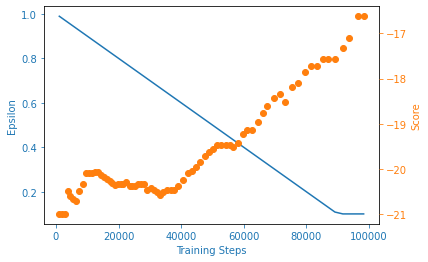

episode:  75 score:  -13.0  average score -19.0 best score -19.04 epsilon 0.10 steps 100406
... saving checkpoint ...
... saving checkpoint ...


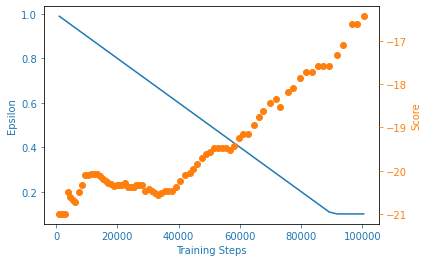

episode:  76 score:  -20.0  average score -19.0 best score -18.96 epsilon 0.10 steps 102026


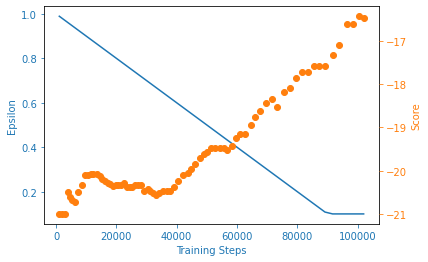

episode:  77 score:  -8.0  average score -18.8 best score -18.96 epsilon 0.10 steps 104644
... saving checkpoint ...
... saving checkpoint ...


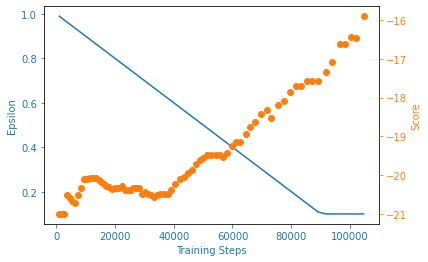

episode:  78 score:  -16.0  average score -18.8 best score -18.83 epsilon 0.10 steps 106522
... saving checkpoint ...
... saving checkpoint ...


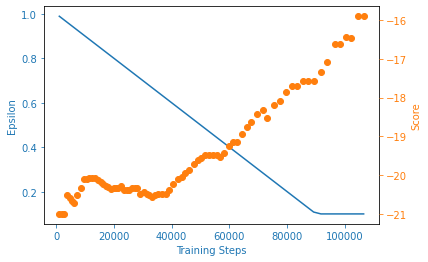

episode:  79 score:  -13.0  average score -18.7 best score -18.80 epsilon 0.10 steps 108798
... saving checkpoint ...
... saving checkpoint ...


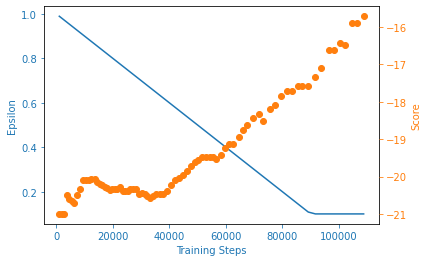

episode:  80 score:  -18.0  average score -18.7 best score -18.73 epsilon 0.10 steps 110414
... saving checkpoint ...
... saving checkpoint ...


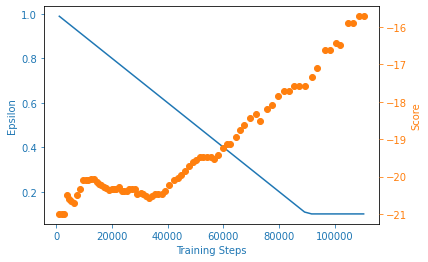

episode:  81 score:  -4.0  average score -18.5 best score -18.72 epsilon 0.10 steps 113287
... saving checkpoint ...
... saving checkpoint ...


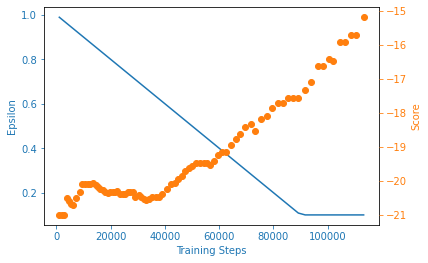

episode:  82 score:  -11.0  average score -18.4 best score -18.54 epsilon 0.10 steps 115806
... saving checkpoint ...
... saving checkpoint ...


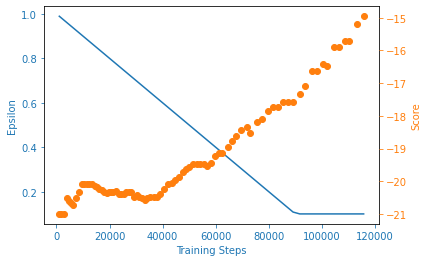

episode:  83 score:  -10.0  average score -18.3 best score -18.45 epsilon 0.10 steps 118934
... saving checkpoint ...
... saving checkpoint ...


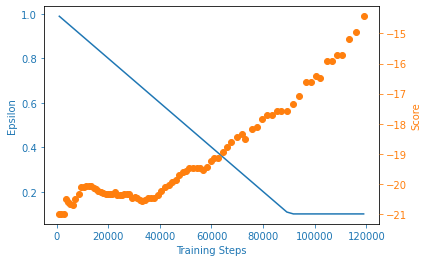

episode:  84 score:  -13.0  average score -18.3 best score -18.35 epsilon 0.10 steps 120983
... saving checkpoint ...
... saving checkpoint ...


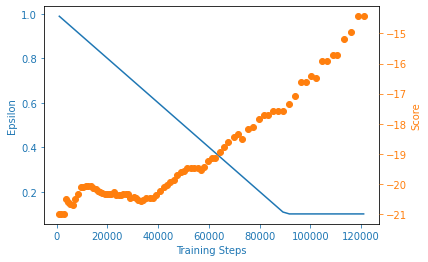

episode:  85 score:  2.0  average score -18.0 best score -18.28 epsilon 0.10 steps 124449
... saving checkpoint ...
... saving checkpoint ...


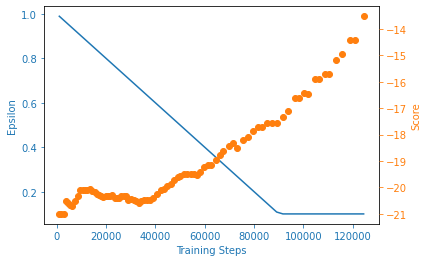

episode:  86 score:  -2.0  average score -17.9 best score -18.05 epsilon 0.10 steps 127721
... saving checkpoint ...
... saving checkpoint ...


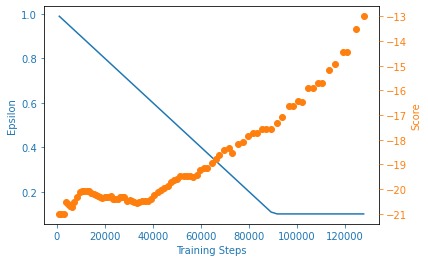

episode:  87 score:  -8.0  average score -17.8 best score -17.86 epsilon 0.10 steps 130325
... saving checkpoint ...
... saving checkpoint ...


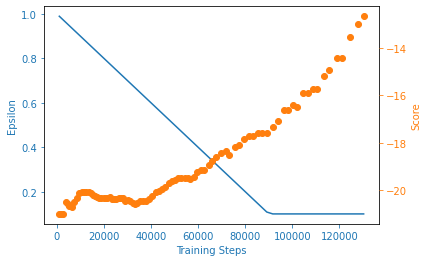

episode:  88 score:  -8.0  average score -17.6 best score -17.75 epsilon 0.10 steps 133301
... saving checkpoint ...
... saving checkpoint ...


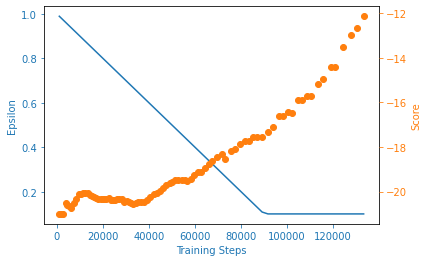

episode:  89 score:  4.0  average score -17.4 best score -17.64 epsilon 0.10 steps 136256
... saving checkpoint ...
... saving checkpoint ...


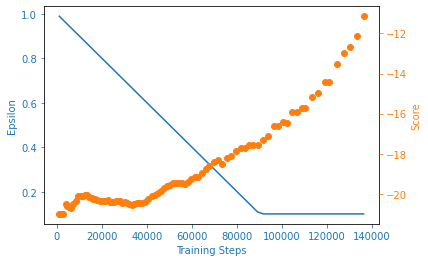

episode:  90 score:  7.0  average score -17.1 best score -17.40 epsilon 0.10 steps 139003
... saving checkpoint ...
... saving checkpoint ...


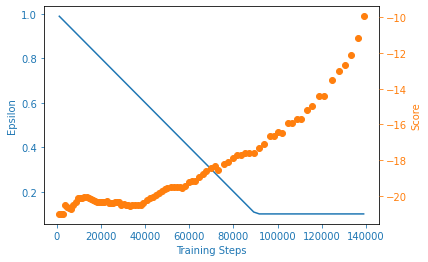

episode:  91 score:  -1.0  average score -17.0 best score -17.13 epsilon 0.10 steps 142092
... saving checkpoint ...
... saving checkpoint ...


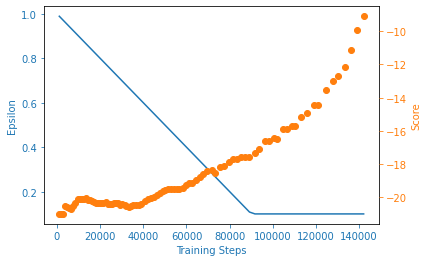

episode:  92 score:  -10.0  average score -16.9 best score -16.96 epsilon 0.10 steps 144593
... saving checkpoint ...
... saving checkpoint ...


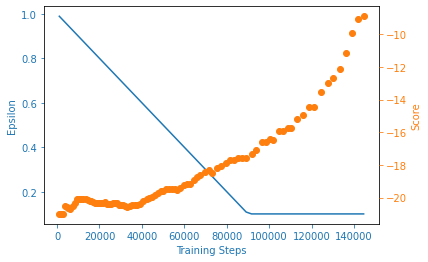

episode:  93 score:  -3.0  average score -16.7 best score -16.88 epsilon 0.10 steps 147592
... saving checkpoint ...
... saving checkpoint ...


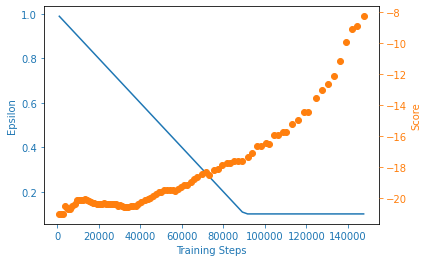

episode:  94 score:  -8.0  average score -16.6 best score -16.73 epsilon 0.10 steps 150261
... saving checkpoint ...
... saving checkpoint ...


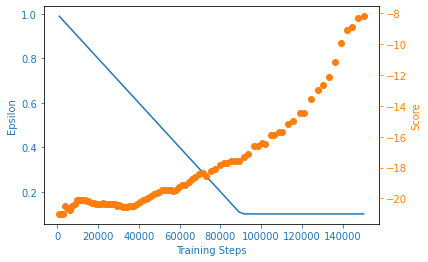

episode:  95 score:  6.0  average score -16.4 best score -16.64 epsilon 0.10 steps 152870
... saving checkpoint ...
... saving checkpoint ...


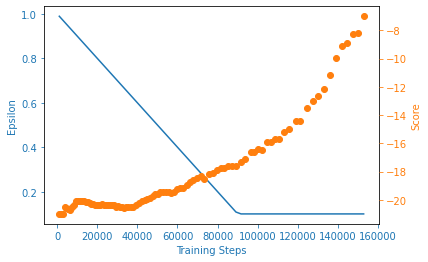

episode:  96 score:  5.0  average score -16.2 best score -16.41 epsilon 0.10 steps 155618
... saving checkpoint ...
... saving checkpoint ...


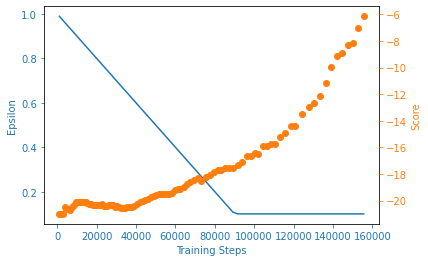

episode:  97 score:  9.0  average score -15.9 best score -16.19 epsilon 0.10 steps 158454
... saving checkpoint ...
... saving checkpoint ...


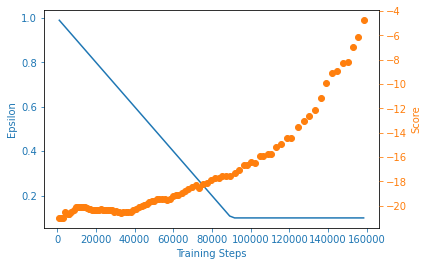

episode:  98 score:  -1.0  average score -15.8 best score -15.93 epsilon 0.10 steps 162014
... saving checkpoint ...
... saving checkpoint ...


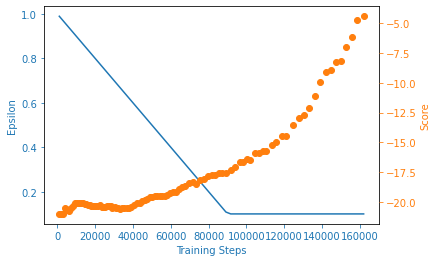

episode:  99 score:  4.0  average score -15.6 best score -15.78 epsilon 0.10 steps 165006
... saving checkpoint ...
... saving checkpoint ...


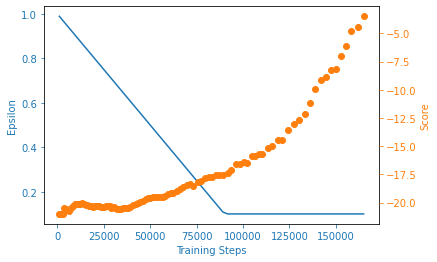

episode:  100 score:  6.0  average score -15.3 best score -15.58 epsilon 0.10 steps 167977
... saving checkpoint ...
... saving checkpoint ...


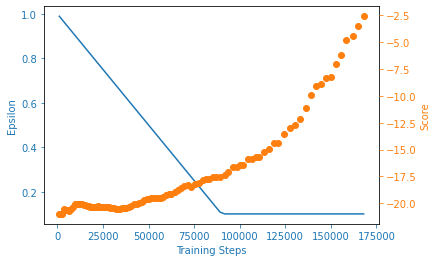

episode:  101 score:  14.0  average score -15.0 best score -15.31 epsilon 0.10 steps 170113
... saving checkpoint ...
... saving checkpoint ...


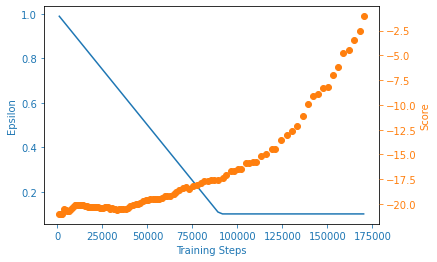

episode:  102 score:  3.0  average score -14.7 best score -14.96 epsilon 0.10 steps 173347
... saving checkpoint ...
... saving checkpoint ...


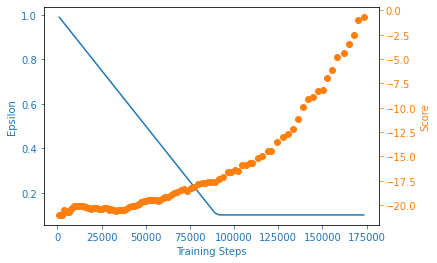

episode:  103 score:  7.0  average score -14.5 best score -14.72 epsilon 0.10 steps 176174
... saving checkpoint ...
... saving checkpoint ...


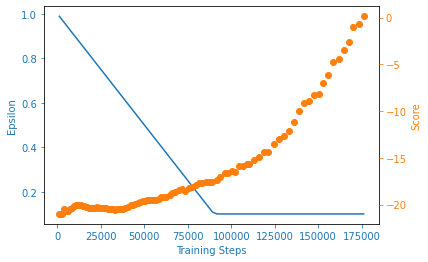

episode:  104 score:  13.0  average score -14.1 best score -14.46 epsilon 0.10 steps 178738
... saving checkpoint ...
... saving checkpoint ...


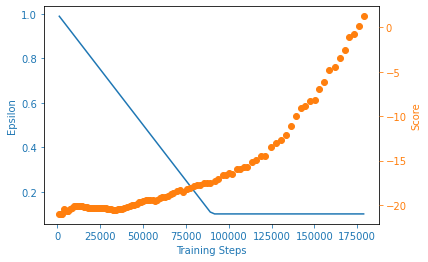

episode:  105 score:  16.0  average score -13.8 best score -14.12 epsilon 0.10 steps 180957
... saving checkpoint ...
... saving checkpoint ...


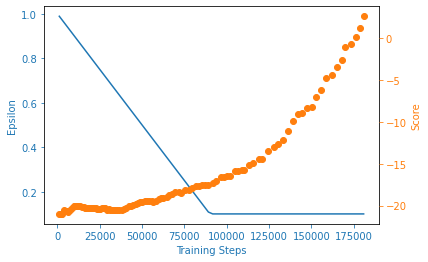

episode:  106 score:  10.0  average score -13.4 best score -13.75 epsilon 0.10 steps 183792
... saving checkpoint ...
... saving checkpoint ...


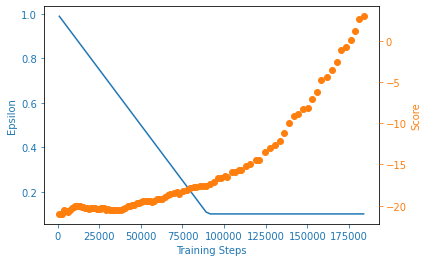

episode:  107 score:  8.0  average score -13.2 best score -13.44 epsilon 0.10 steps 186411
... saving checkpoint ...
... saving checkpoint ...


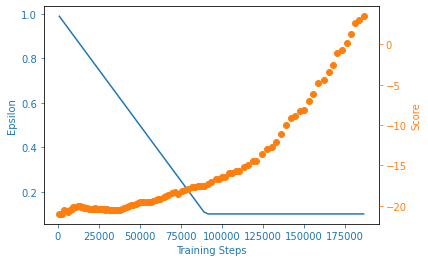

episode:  108 score:  12.0  average score -12.9 best score -13.17 epsilon 0.10 steps 189125
... saving checkpoint ...
... saving checkpoint ...


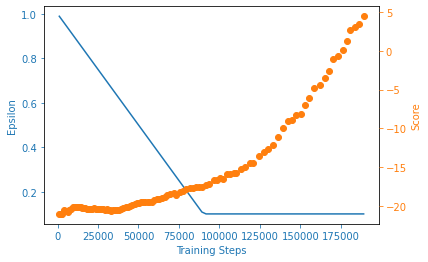

episode:  109 score:  9.0  average score -12.6 best score -12.86 epsilon 0.10 steps 192122
... saving checkpoint ...
... saving checkpoint ...


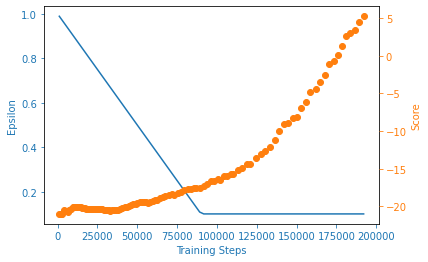

episode:  110 score:  1.0  average score -12.4 best score -12.59 epsilon 0.10 steps 195578
... saving checkpoint ...
... saving checkpoint ...


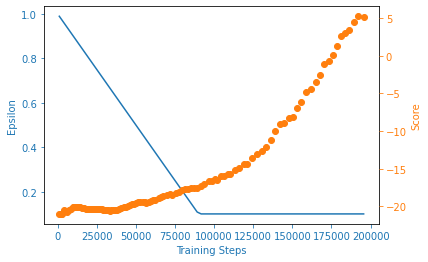

episode:  111 score:  7.0  average score -12.1 best score -12.38 epsilon 0.10 steps 198626
... saving checkpoint ...
... saving checkpoint ...


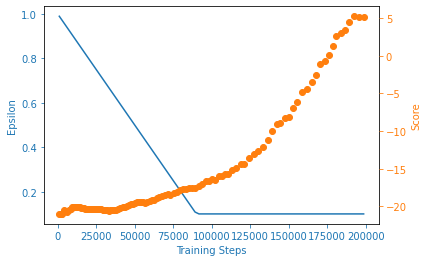

episode:  112 score:  -1.0  average score -11.9 best score -12.11 epsilon 0.10 steps 202226
... saving checkpoint ...
... saving checkpoint ...


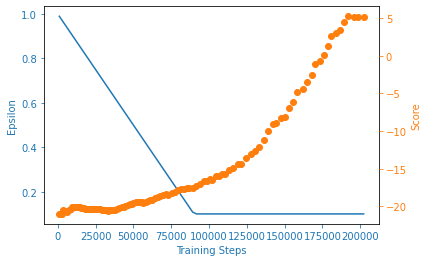

episode:  113 score:  4.0  average score -11.7 best score -11.92 epsilon 0.10 steps 205796
... saving checkpoint ...
... saving checkpoint ...


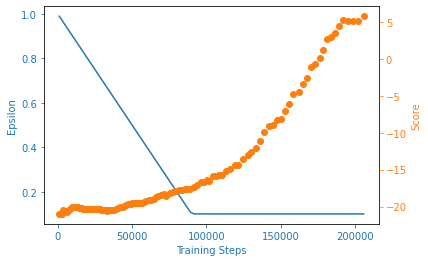

episode:  114 score:  8.0  average score -11.4 best score -11.68 epsilon 0.10 steps 208668
... saving checkpoint ...
... saving checkpoint ...


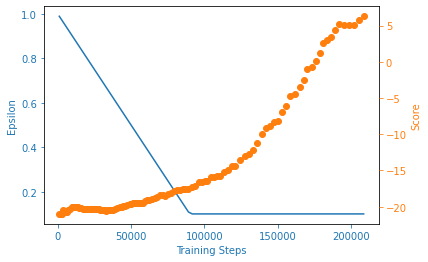

episode:  115 score:  12.0  average score -11.1 best score -11.39 epsilon 0.10 steps 211255
... saving checkpoint ...
... saving checkpoint ...


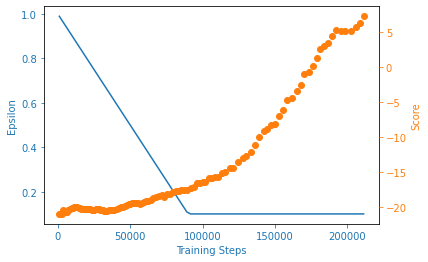

episode:  116 score:  9.0  average score -10.8 best score -11.06 epsilon 0.10 steps 214438
... saving checkpoint ...
... saving checkpoint ...


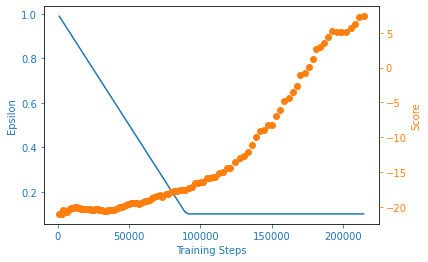

episode:  117 score:  16.0  average score -10.4 best score -10.76 epsilon 0.10 steps 216648
... saving checkpoint ...
... saving checkpoint ...


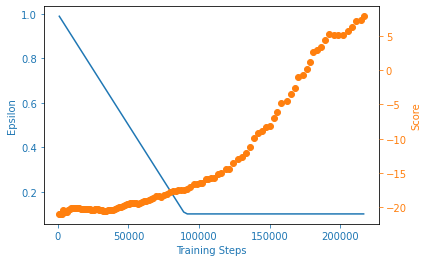

episode:  118 score:  14.0  average score -10.0 best score -10.39 epsilon 0.10 steps 218887
... saving checkpoint ...
... saving checkpoint ...


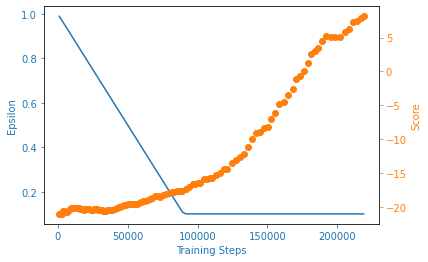

episode:  119 score:  12.0  average score -9.7 best score -10.04 epsilon 0.10 steps 221544
... saving checkpoint ...
... saving checkpoint ...


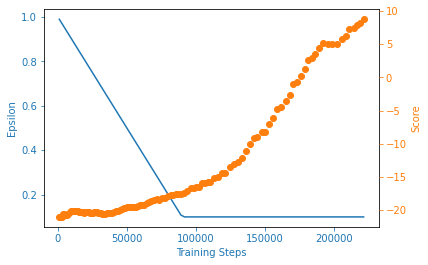

episode:  120 score:  13.0  average score -9.4 best score -9.71 epsilon 0.10 steps 223814
... saving checkpoint ...
... saving checkpoint ...


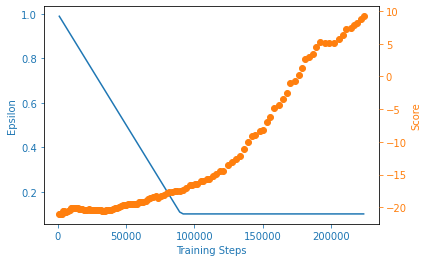

episode:  121 score:  15.0  average score -9.0 best score -9.38 epsilon 0.10 steps 226300
... saving checkpoint ...
... saving checkpoint ...


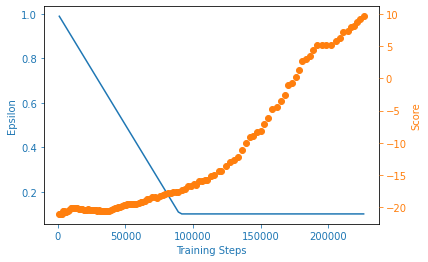

episode:  122 score:  9.0  average score -8.7 best score -9.02 epsilon 0.10 steps 229029
... saving checkpoint ...
... saving checkpoint ...


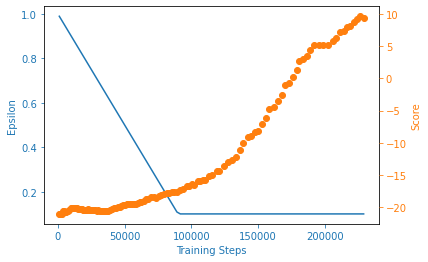

episode:  123 score:  10.0  average score -8.4 best score -8.72 epsilon 0.10 steps 232328
... saving checkpoint ...
... saving checkpoint ...


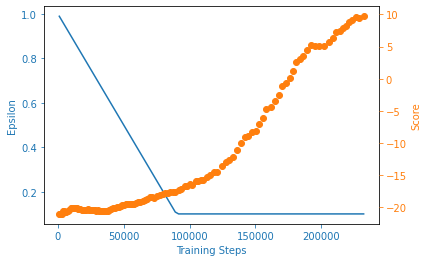

episode:  124 score:  9.0  average score -8.1 best score -8.42 epsilon 0.10 steps 235510
... saving checkpoint ...
... saving checkpoint ...


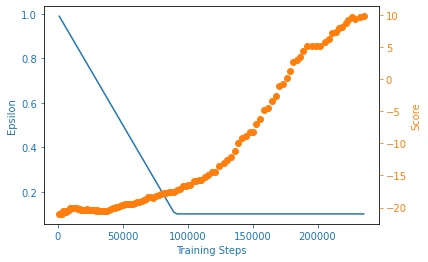

episode:  125 score:  14.0  average score -7.8 best score -8.12 epsilon 0.10 steps 237723
... saving checkpoint ...
... saving checkpoint ...


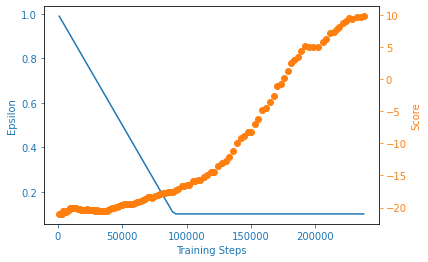

episode:  126 score:  15.0  average score -7.4 best score -7.77 epsilon 0.10 steps 239924
... saving checkpoint ...
... saving checkpoint ...


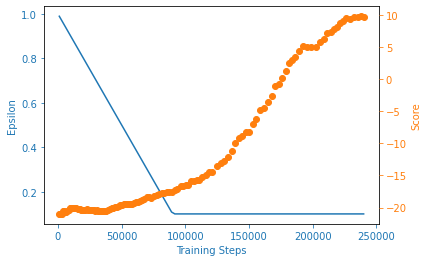

episode:  127 score:  13.0  average score -7.1 best score -7.41 epsilon 0.10 steps 242549
... saving checkpoint ...
... saving checkpoint ...


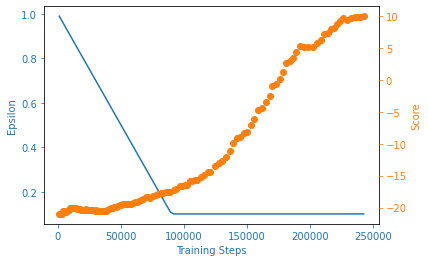

episode:  128 score:  13.0  average score -6.8 best score -7.08 epsilon 0.10 steps 244992
... saving checkpoint ...
... saving checkpoint ...


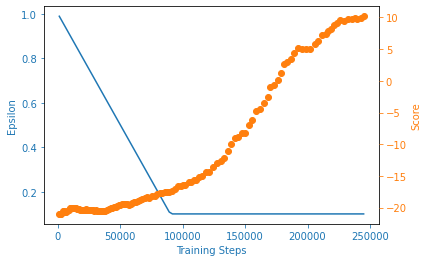

episode:  129 score:  15.0  average score -6.4 best score -6.76 epsilon 0.10 steps 247464
... saving checkpoint ...
... saving checkpoint ...


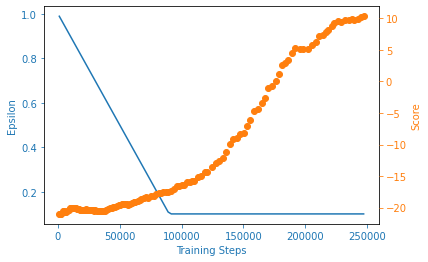

episode:  130 score:  5.0  average score -6.2 best score -6.42 epsilon 0.10 steps 250620
... saving checkpoint ...
... saving checkpoint ...


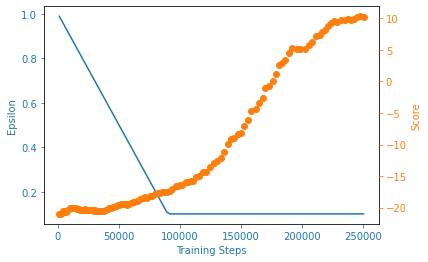

episode:  131 score:  13.0  average score -5.8 best score -6.16 epsilon 0.10 steps 253072
... saving checkpoint ...
... saving checkpoint ...


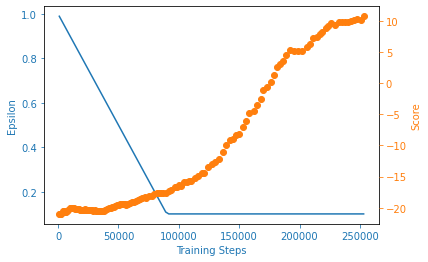

episode:  132 score:  14.0  average score -5.5 best score -5.84 epsilon 0.10 steps 255603
... saving checkpoint ...
... saving checkpoint ...


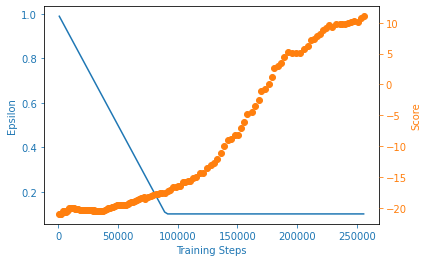

episode:  133 score:  -1.0  average score -5.3 best score -5.49 epsilon 0.10 steps 259068
... saving checkpoint ...
... saving checkpoint ...


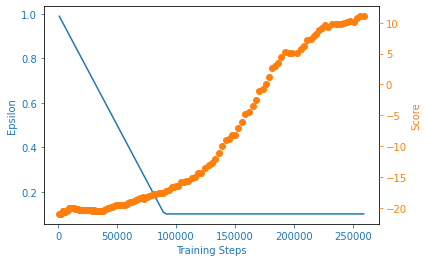

episode:  134 score:  8.0  average score -5.0 best score -5.29 epsilon 0.10 steps 262169
... saving checkpoint ...
... saving checkpoint ...


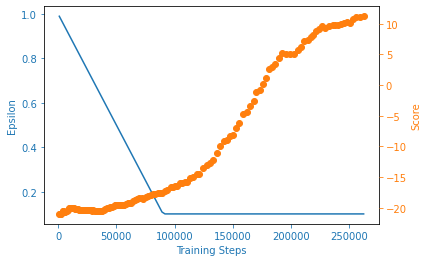

episode:  135 score:  16.0  average score -4.6 best score -5.00 epsilon 0.10 steps 264327
... saving checkpoint ...
... saving checkpoint ...


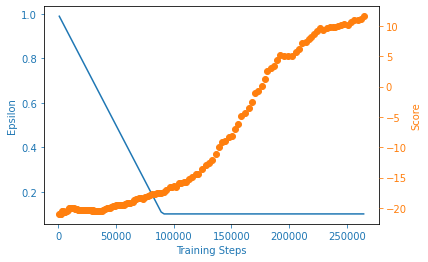

episode:  136 score:  11.0  average score -4.3 best score -4.64 epsilon 0.10 steps 266945
... saving checkpoint ...
... saving checkpoint ...


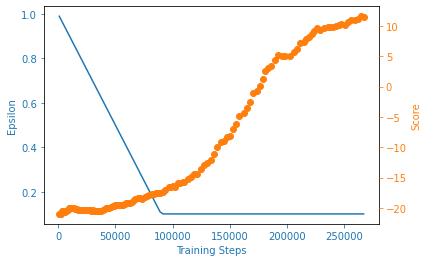

episode:  137 score:  11.0  average score -4.0 best score -4.33 epsilon 0.10 steps 269495
... saving checkpoint ...
... saving checkpoint ...


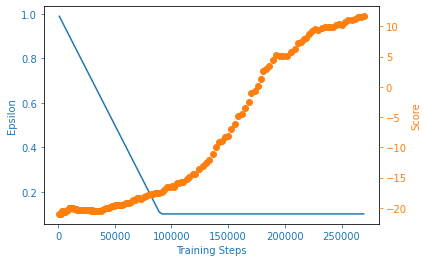

episode:  138 score:  17.0  average score -3.6 best score -4.01 epsilon 0.10 steps 271662
... saving checkpoint ...
... saving checkpoint ...


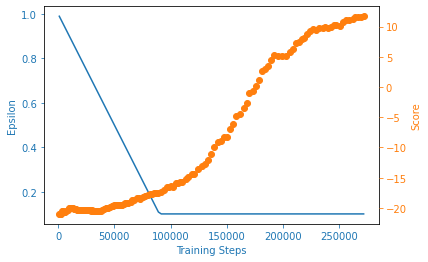

episode:  139 score:  8.0  average score -3.4 best score -3.63 epsilon 0.10 steps 274243
... saving checkpoint ...
... saving checkpoint ...


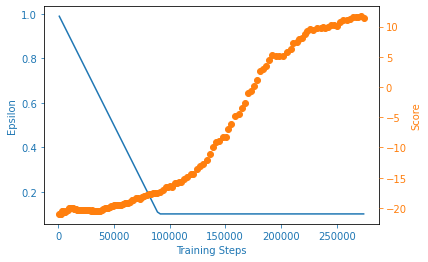

episode:  140 score:  15.0  average score -3.0 best score -3.36 epsilon 0.10 steps 276443
... saving checkpoint ...
... saving checkpoint ...


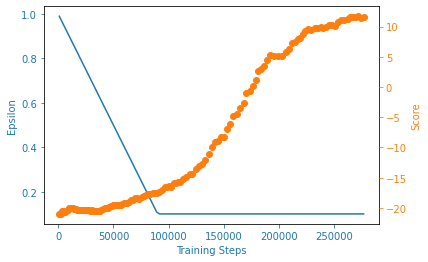

episode:  141 score:  5.0  average score -2.8 best score -3.03 epsilon 0.10 steps 279209
... saving checkpoint ...
... saving checkpoint ...


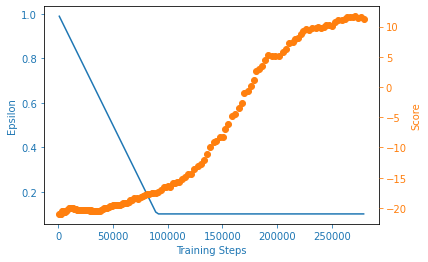

episode:  142 score:  10.0  average score -2.5 best score -2.81 epsilon 0.10 steps 281612
... saving checkpoint ...
... saving checkpoint ...


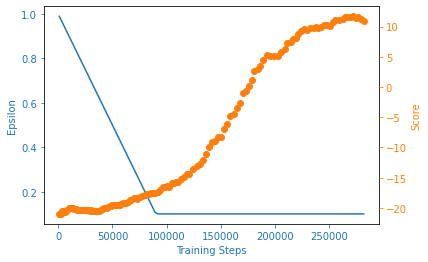

episode:  143 score:  4.0  average score -2.3 best score -2.51 epsilon 0.10 steps 284714
... saving checkpoint ...
... saving checkpoint ...


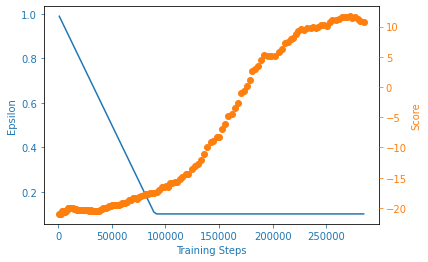

episode:  144 score:  15.0  average score -1.9 best score -2.28 epsilon 0.10 steps 286982
... saving checkpoint ...
... saving checkpoint ...


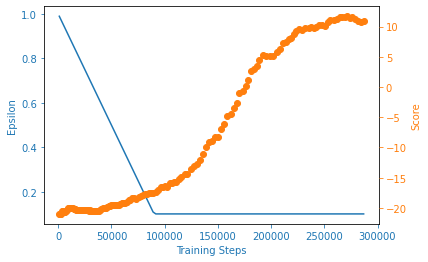

episode:  145 score:  15.0  average score -1.6 best score -1.95 epsilon 0.10 steps 289166
... saving checkpoint ...
... saving checkpoint ...


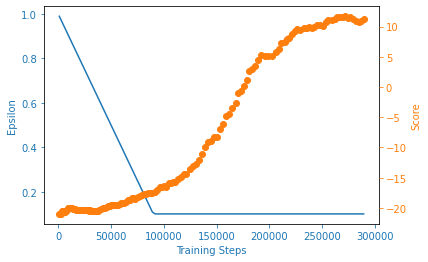

episode:  146 score:  11.0  average score -1.3 best score -1.62 epsilon 0.10 steps 291448
... saving checkpoint ...
... saving checkpoint ...


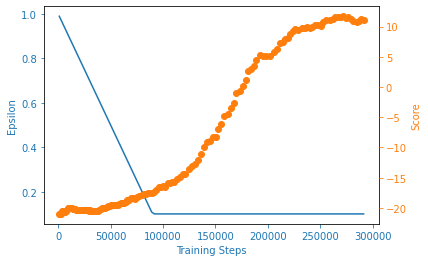

episode:  147 score:  9.0  average score -1.0 best score -1.32 epsilon 0.10 steps 293994
... saving checkpoint ...
... saving checkpoint ...


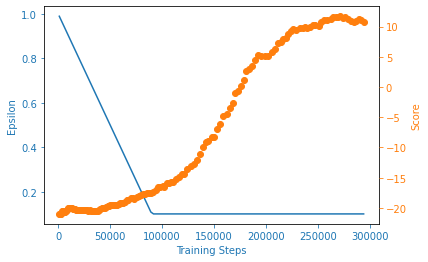

episode:  148 score:  10.0  average score -0.8 best score -1.03 epsilon 0.10 steps 296213
... saving checkpoint ...
... saving checkpoint ...


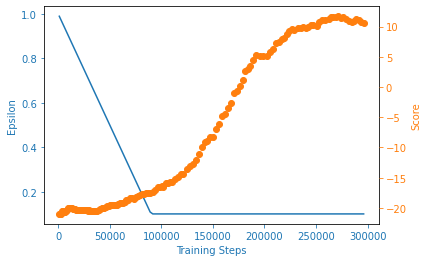

episode:  149 score:  14.0  average score -0.4 best score -0.75 epsilon 0.10 steps 298555
... saving checkpoint ...
... saving checkpoint ...


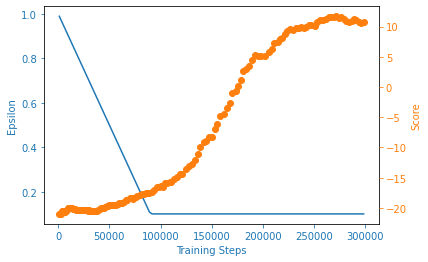

episode:  150 score:  17.0  average score -0.1 best score -0.42 epsilon 0.10 steps 300707
... saving checkpoint ...
... saving checkpoint ...


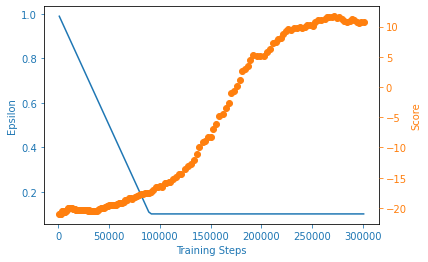

episode:  151 score:  10.0  average score 0.2 best score -0.06 epsilon 0.10 steps 303049
... saving checkpoint ...
... saving checkpoint ...


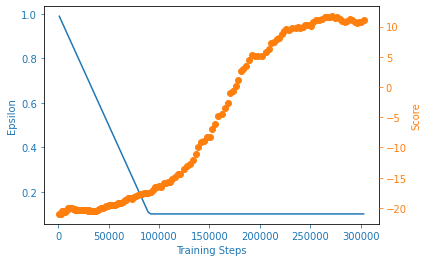

episode:  152 score:  14.0  average score 0.6 best score 0.25 epsilon 0.10 steps 305258
... saving checkpoint ...
... saving checkpoint ...


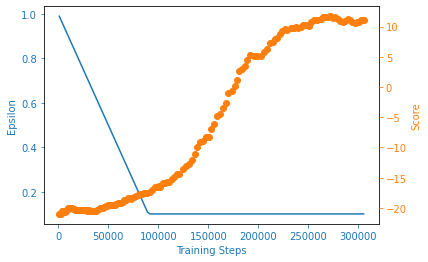

episode:  153 score:  12.0  average score 0.9 best score 0.59 epsilon 0.10 steps 307638
... saving checkpoint ...
... saving checkpoint ...


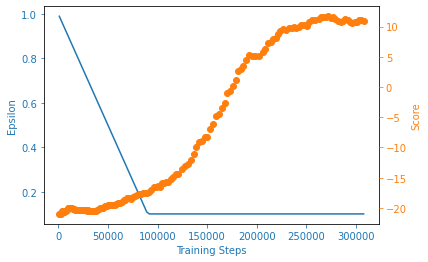

episode:  154 score:  2.0  average score 1.1 best score 0.90 epsilon 0.10 steps 310904
... saving checkpoint ...
... saving checkpoint ...


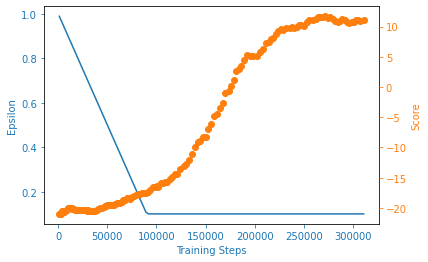

episode:  155 score:  13.0  average score 1.4 best score 1.09 epsilon 0.10 steps 313409
... saving checkpoint ...
... saving checkpoint ...


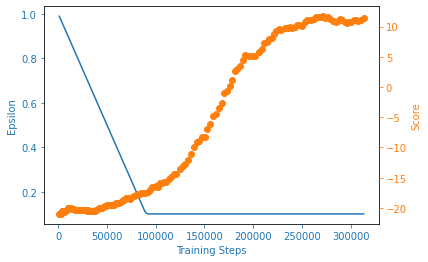

episode:  156 score:  15.0  average score 1.8 best score 1.41 epsilon 0.10 steps 315702
... saving checkpoint ...
... saving checkpoint ...


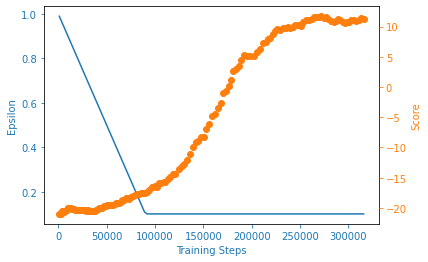

episode:  157 score:  14.0  average score 2.1 best score 1.76 epsilon 0.10 steps 317814
... saving checkpoint ...
... saving checkpoint ...


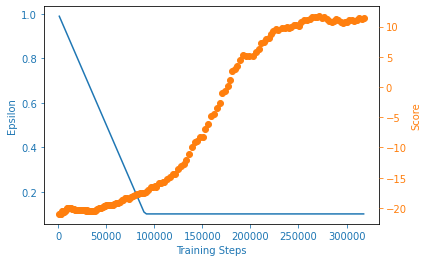

episode:  158 score:  6.0  average score 2.3 best score 2.06 epsilon 0.10 steps 320390
... saving checkpoint ...
... saving checkpoint ...


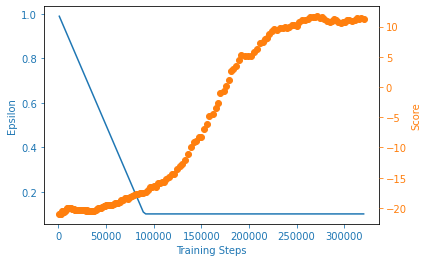

episode:  159 score:  16.0  average score 2.6 best score 2.29 epsilon 0.10 steps 322587
... saving checkpoint ...
... saving checkpoint ...


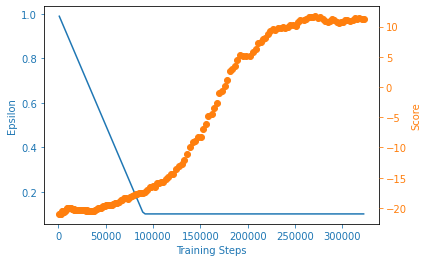

episode:  160 score:  16.0  average score 2.9 best score 2.63 epsilon 0.10 steps 324628
... saving checkpoint ...
... saving checkpoint ...


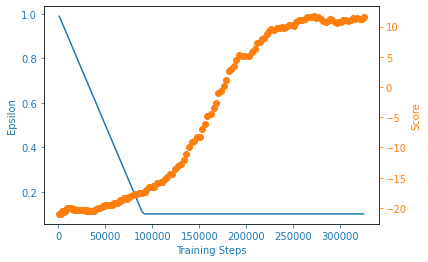

episode:  161 score:  13.0  average score 3.2 best score 2.94 epsilon 0.10 steps 327165
... saving checkpoint ...
... saving checkpoint ...


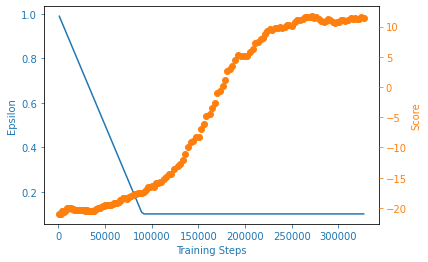

episode:  162 score:  10.0  average score 3.5 best score 3.23 epsilon 0.10 steps 329827
... saving checkpoint ...
... saving checkpoint ...


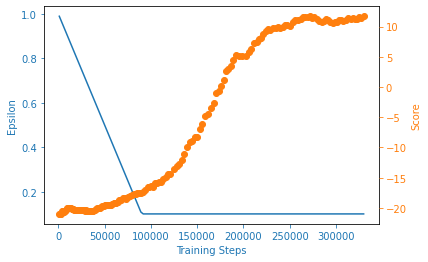

episode:  163 score:  10.0  average score 3.8 best score 3.54 epsilon 0.10 steps 332392
... saving checkpoint ...
... saving checkpoint ...


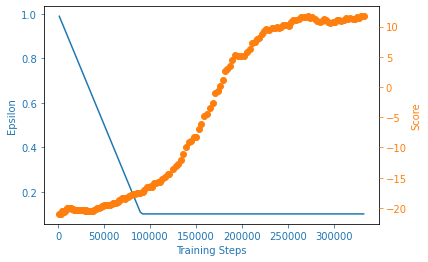

episode:  164 score:  6.0  average score 4.0 best score 3.77 epsilon 0.10 steps 335150
... saving checkpoint ...
... saving checkpoint ...


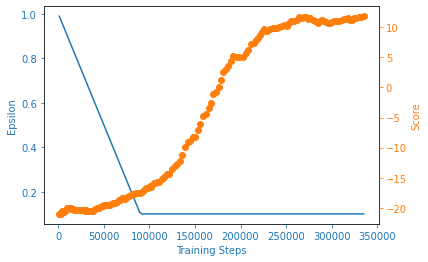

episode:  165 score:  9.0  average score 4.2 best score 4.00 epsilon 0.10 steps 337834
... saving checkpoint ...
... saving checkpoint ...


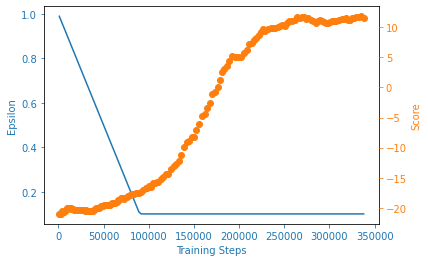

episode:  166 score:  15.0  average score 4.5 best score 4.22 epsilon 0.10 steps 340203
... saving checkpoint ...
... saving checkpoint ...


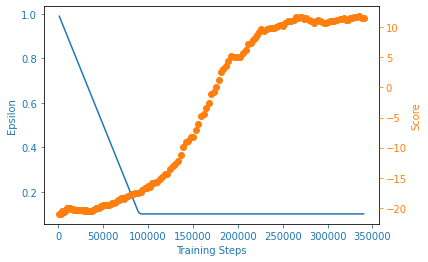

episode:  167 score:  8.0  average score 4.8 best score 4.52 epsilon 0.10 steps 342897
... saving checkpoint ...
... saving checkpoint ...


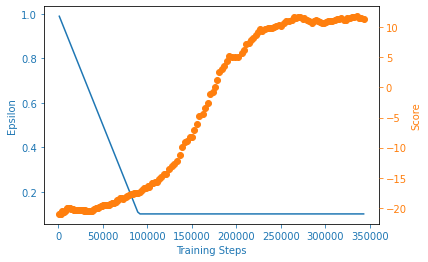

episode:  168 score:  10.0  average score 5.1 best score 4.79 epsilon 0.10 steps 345447
... saving checkpoint ...
... saving checkpoint ...


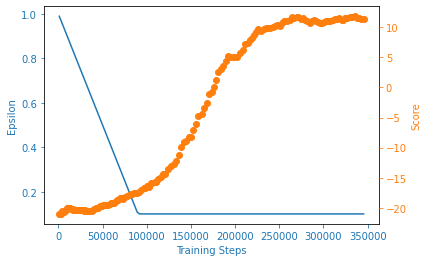

episode:  169 score:  10.0  average score 5.3 best score 5.06 epsilon 0.10 steps 348365
... saving checkpoint ...
... saving checkpoint ...


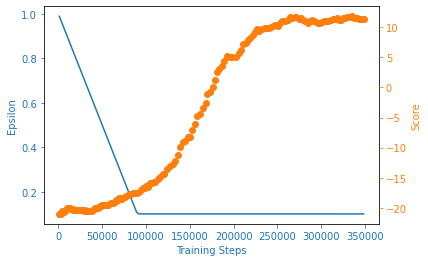

episode:  170 score:  11.0  average score 5.6 best score 5.34 epsilon 0.10 steps 350836
... saving checkpoint ...
... saving checkpoint ...


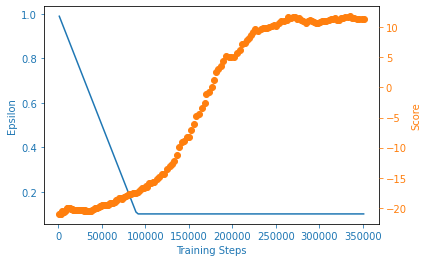

episode:  171 score:  10.0  average score 5.9 best score 5.64 epsilon 0.10 steps 353307
... saving checkpoint ...
... saving checkpoint ...


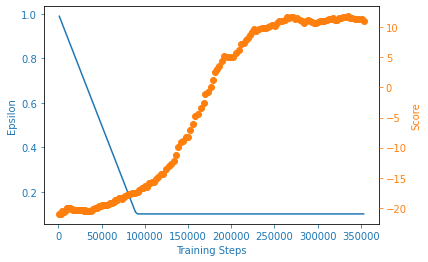

episode:  172 score:  13.0  average score 6.2 best score 5.88 epsilon 0.10 steps 355661
... saving checkpoint ...
... saving checkpoint ...


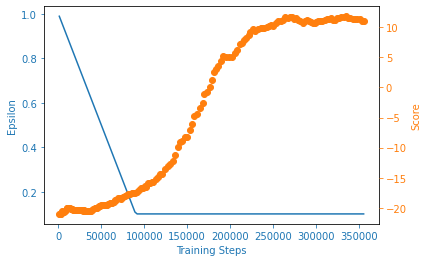

episode:  173 score:  11.0  average score 6.4 best score 6.17 epsilon 0.10 steps 358038
... saving checkpoint ...
... saving checkpoint ...


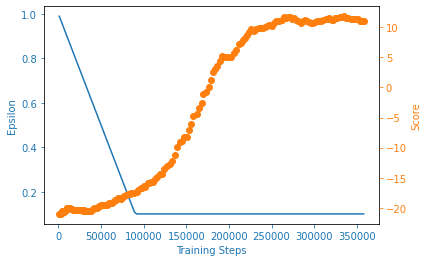

episode:  174 score:  16.0  average score 6.7 best score 6.38 epsilon 0.10 steps 360081
... saving checkpoint ...
... saving checkpoint ...


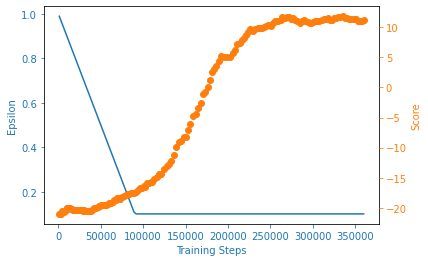

episode:  175 score:  4.0  average score 6.9 best score 6.73 epsilon 0.10 steps 362884
... saving checkpoint ...
... saving checkpoint ...


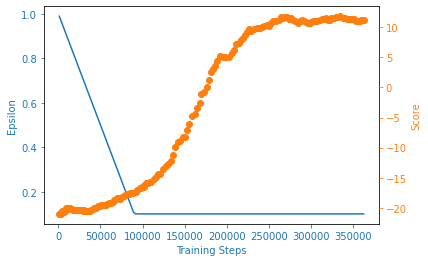

episode:  176 score:  16.0  average score 7.3 best score 6.90 epsilon 0.10 steps 364986
... saving checkpoint ...
... saving checkpoint ...


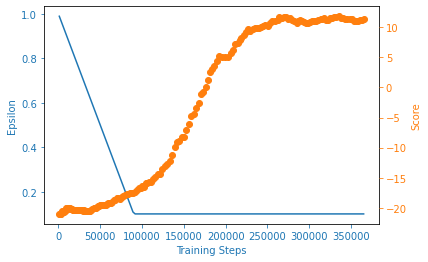

episode:  177 score:  3.0  average score 7.4 best score 7.26 epsilon 0.10 steps 367860
... saving checkpoint ...
... saving checkpoint ...


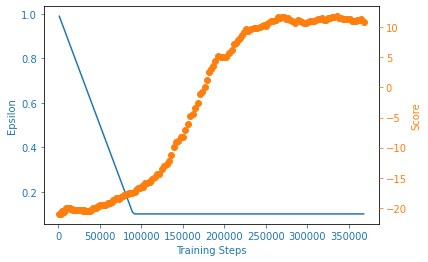

episode:  178 score:  3.0  average score 7.6 best score 7.37 epsilon 0.10 steps 371103
... saving checkpoint ...
... saving checkpoint ...


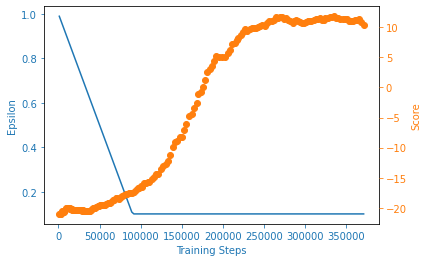

episode:  179 score:  9.0  average score 7.8 best score 7.56 epsilon 0.10 steps 373773
... saving checkpoint ...
... saving checkpoint ...


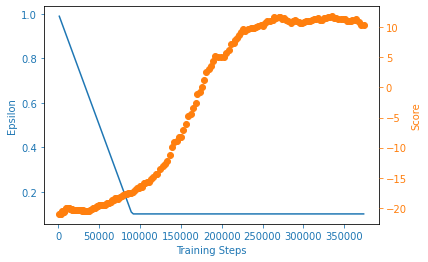

episode:  180 score:  10.0  average score 8.1 best score 7.78 epsilon 0.10 steps 376228
... saving checkpoint ...
... saving checkpoint ...


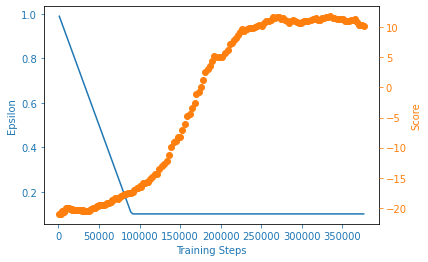

episode:  181 score:  13.0  average score 8.2 best score 8.06 epsilon 0.10 steps 378878
... saving checkpoint ...
... saving checkpoint ...


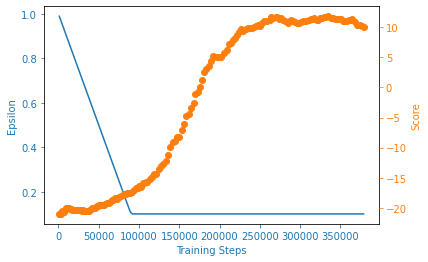

episode:  182 score:  9.0  average score 8.4 best score 8.23 epsilon 0.10 steps 381539
... saving checkpoint ...
... saving checkpoint ...


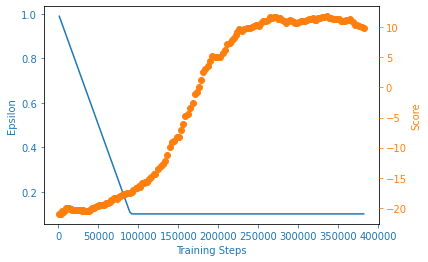

episode:  183 score:  14.0  average score 8.7 best score 8.43 epsilon 0.10 steps 383704
... saving checkpoint ...
... saving checkpoint ...


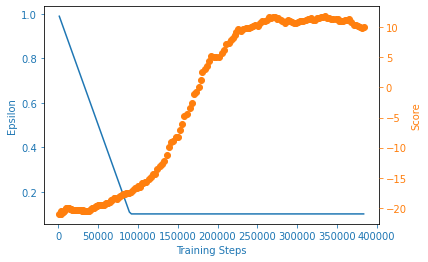

episode:  184 score:  21.0  average score 9.0 best score 8.67 epsilon 0.10 steps 385403
... saving checkpoint ...
... saving checkpoint ...


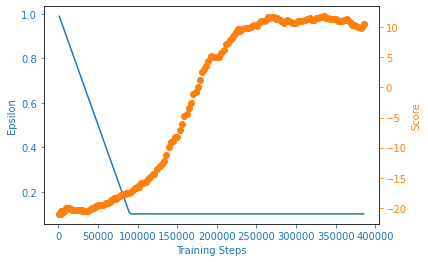

episode:  185 score:  14.0  average score 9.1 best score 9.01 epsilon 0.10 steps 387647
... saving checkpoint ...
... saving checkpoint ...


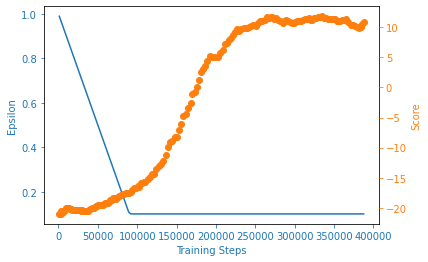

episode:  186 score:  -3.0  average score 9.1 best score 9.13 epsilon 0.10 steps 390638


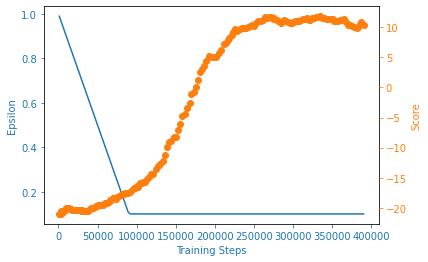

episode:  187 score:  18.0  average score 9.4 best score 9.13 epsilon 0.10 steps 392716
... saving checkpoint ...
... saving checkpoint ...


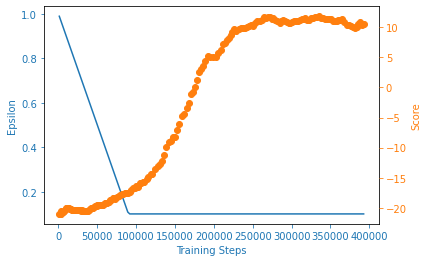

episode:  188 score:  14.0  average score 9.6 best score 9.38 epsilon 0.10 steps 394852
... saving checkpoint ...
... saving checkpoint ...


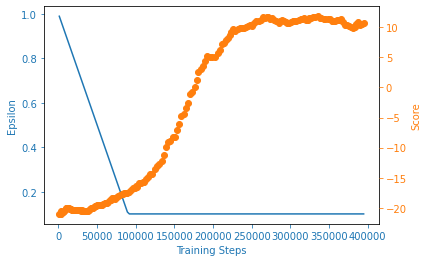

episode:  189 score:  13.0  average score 9.7 best score 9.60 epsilon 0.10 steps 397198
... saving checkpoint ...
... saving checkpoint ...


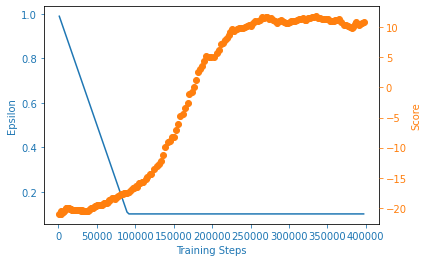

episode:  190 score:  13.0  average score 9.8 best score 9.69 epsilon 0.10 steps 399524
... saving checkpoint ...
... saving checkpoint ...


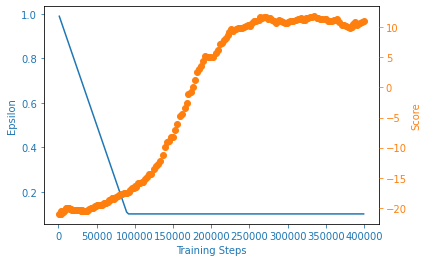

episode:  191 score:  18.0  average score 9.9 best score 9.75 epsilon 0.10 steps 401611
... saving checkpoint ...
... saving checkpoint ...


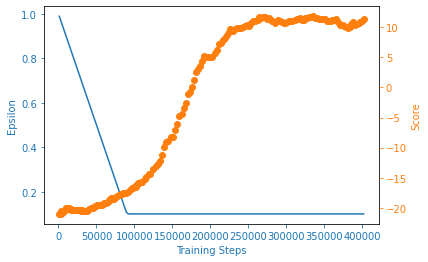

episode:  192 score:  15.0  average score 10.2 best score 9.94 epsilon 0.10 steps 403870
... saving checkpoint ...
... saving checkpoint ...


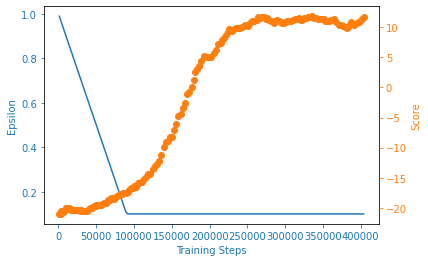

episode:  193 score:  12.0  average score 10.3 best score 10.19 epsilon 0.10 steps 406370
... saving checkpoint ...
... saving checkpoint ...


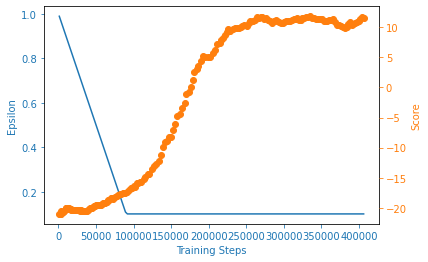

episode:  194 score:  18.0  average score 10.6 best score 10.34 epsilon 0.10 steps 408349
... saving checkpoint ...
... saving checkpoint ...


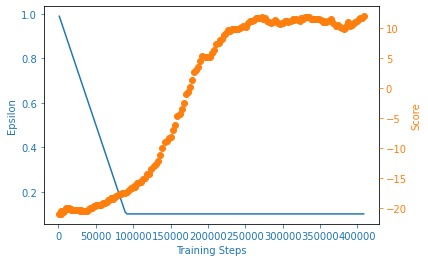

episode:  195 score:  17.0  average score 10.7 best score 10.60 epsilon 0.10 steps 410429
... saving checkpoint ...
... saving checkpoint ...


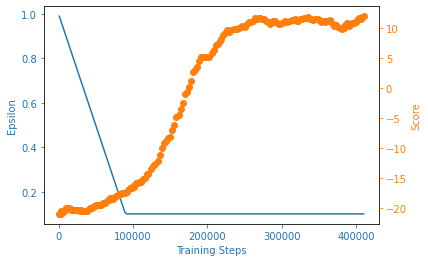

episode:  196 score:  18.0  average score 10.8 best score 10.71 epsilon 0.10 steps 412394
... saving checkpoint ...
... saving checkpoint ...


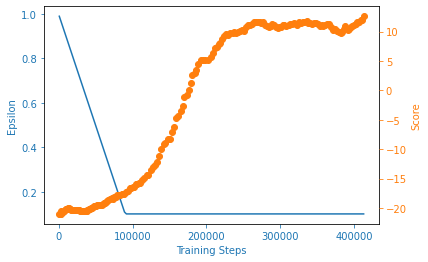

episode:  197 score:  11.0  average score 10.9 best score 10.84 epsilon 0.10 steps 414882
... saving checkpoint ...
... saving checkpoint ...


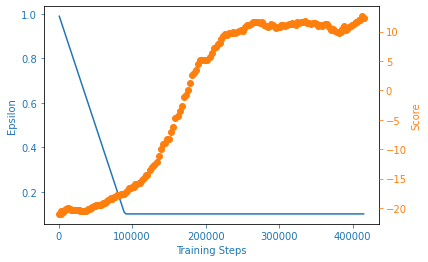

episode:  198 score:  14.0  average score 11.0 best score 10.86 epsilon 0.10 steps 417626
... saving checkpoint ...
... saving checkpoint ...


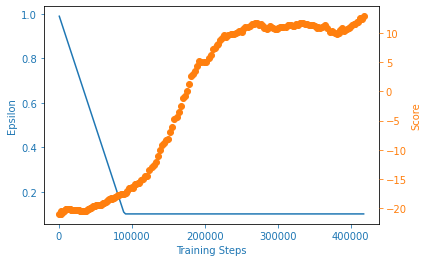

episode:  199 score:  13.0  average score 11.1 best score 11.01 epsilon 0.10 steps 419848
... saving checkpoint ...
... saving checkpoint ...


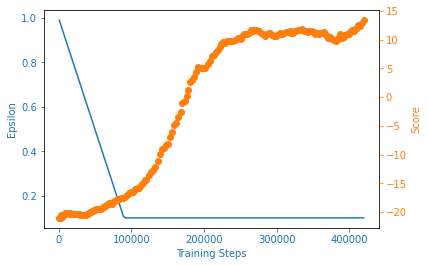

episode:  200 score:  16.0  average score 11.2 best score 11.10 epsilon 0.10 steps 421967
... saving checkpoint ...
... saving checkpoint ...


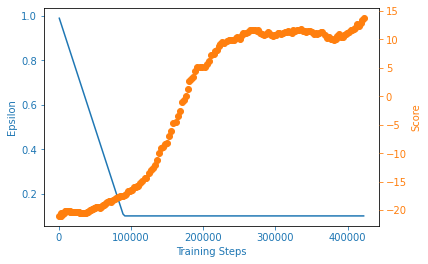

episode:  201 score:  13.0  average score 11.2 best score 11.20 epsilon 0.10 steps 424424


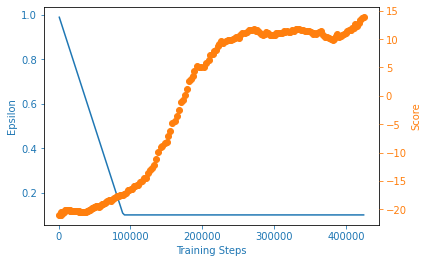

episode:  202 score:  17.0  average score 11.3 best score 11.20 epsilon 0.10 steps 426414
... saving checkpoint ...
... saving checkpoint ...


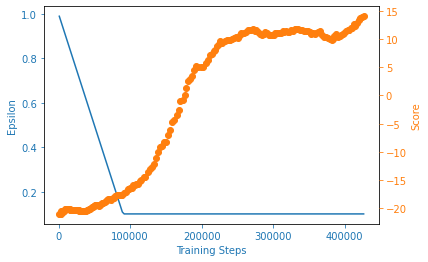

episode:  203 score:  15.0  average score 11.4 best score 11.33 epsilon 0.10 steps 428631
... saving checkpoint ...
... saving checkpoint ...


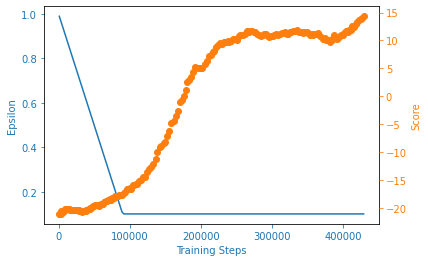

episode:  204 score:  12.0  average score 11.4 best score 11.41 epsilon 0.10 steps 431087


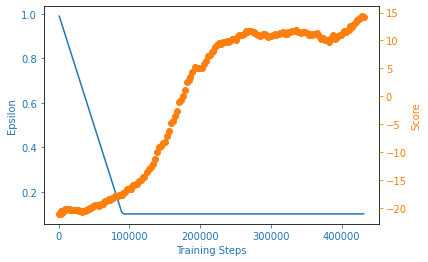

episode:  205 score:  8.0  average score 11.3 best score 11.41 epsilon 0.10 steps 433792


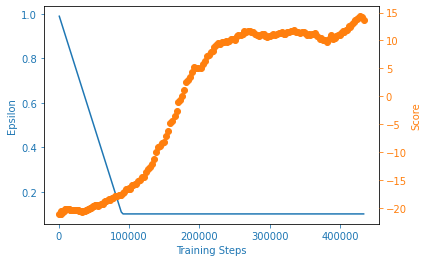

episode:  206 score:  16.0  average score 11.4 best score 11.41 epsilon 0.10 steps 435895


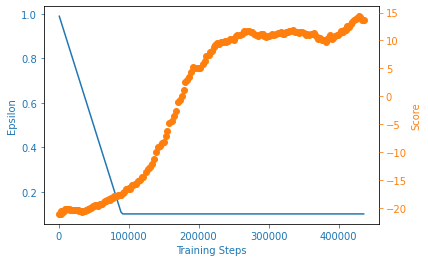

episode:  207 score:  12.0  average score 11.4 best score 11.41 epsilon 0.10 steps 438232
... saving checkpoint ...
... saving checkpoint ...


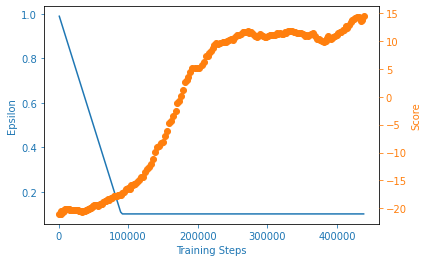

episode:  208 score:  12.0  average score 11.4 best score 11.42 epsilon 0.10 steps 440739


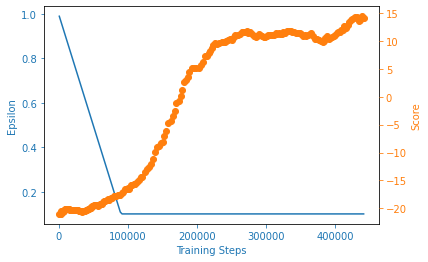

episode:  209 score:  14.0  average score 11.5 best score 11.42 epsilon 0.10 steps 442901
... saving checkpoint ...
... saving checkpoint ...


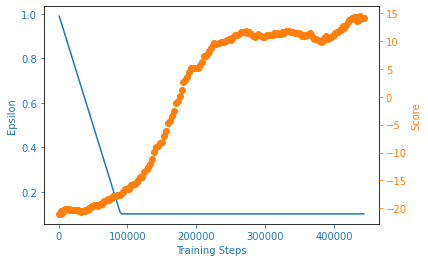

episode:  210 score:  11.0  average score 11.6 best score 11.47 epsilon 0.10 steps 445571
... saving checkpoint ...
... saving checkpoint ...


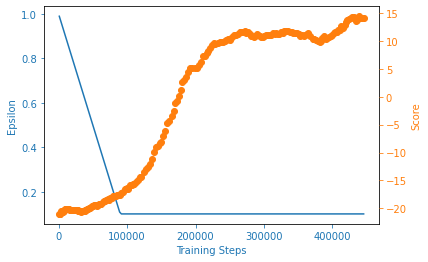

episode:  211 score:  10.0  average score 11.6 best score 11.57 epsilon 0.10 steps 448080
... saving checkpoint ...
... saving checkpoint ...


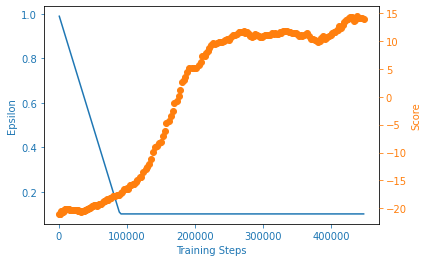

episode:  212 score:  18.0  average score 11.8 best score 11.60 epsilon 0.10 steps 450023
... saving checkpoint ...
... saving checkpoint ...


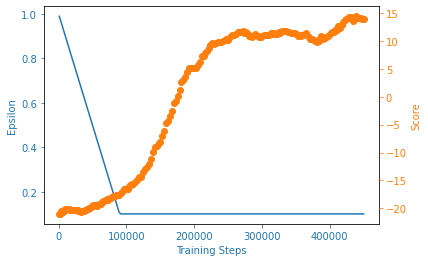

episode:  213 score:  17.0  average score 11.9 best score 11.79 epsilon 0.10 steps 452083
... saving checkpoint ...
... saving checkpoint ...


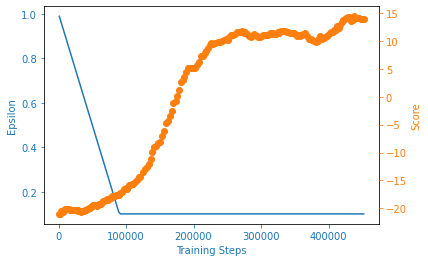

episode:  214 score:  -1.0  average score 11.8 best score 11.92 epsilon 0.10 steps 454677


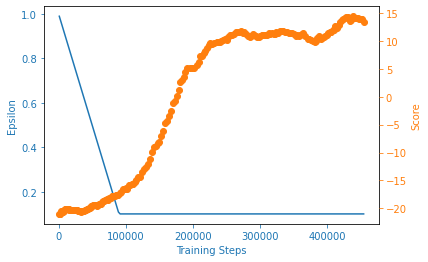

episode:  215 score:  5.0  average score 11.8 best score 11.92 epsilon 0.10 steps 457803


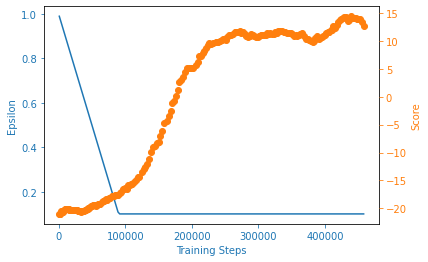

episode:  216 score:  10.0  average score 11.8 best score 11.92 epsilon 0.10 steps 460565


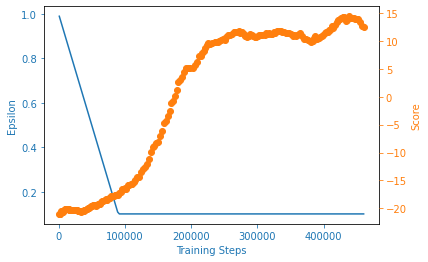

episode:  217 score:  8.0  average score 11.7 best score 11.92 epsilon 0.10 steps 463244


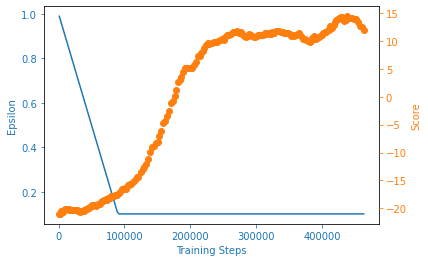

episode:  218 score:  15.0  average score 11.7 best score 11.92 epsilon 0.10 steps 465307


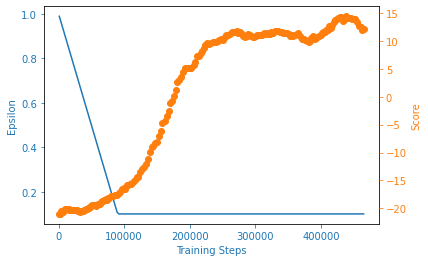

episode:  219 score:  14.0  average score 11.7 best score 11.92 epsilon 0.10 steps 467554


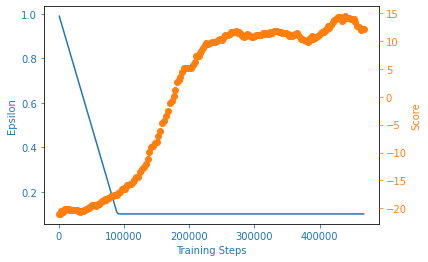

episode:  220 score:  14.0  average score 11.7 best score 11.92 epsilon 0.10 steps 469877


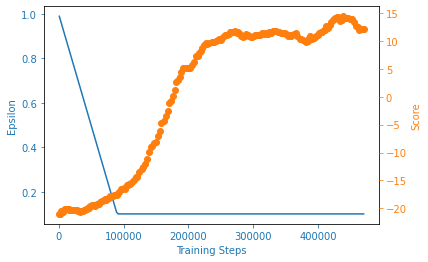

episode:  221 score:  13.0  average score 11.7 best score 11.92 epsilon 0.10 steps 472350


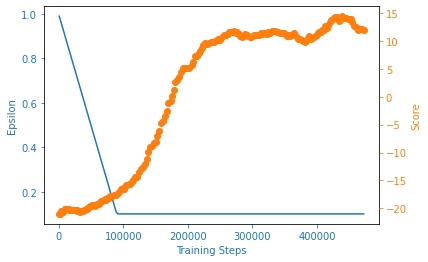

episode:  222 score:  17.0  average score 11.8 best score 11.92 epsilon 0.10 steps 474516


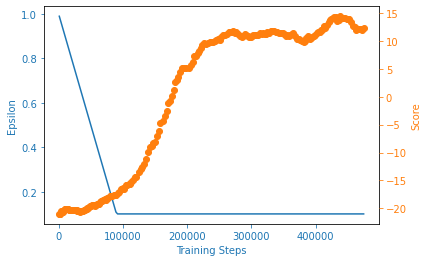

episode:  223 score:  14.0  average score 11.8 best score 11.92 epsilon 0.10 steps 477004


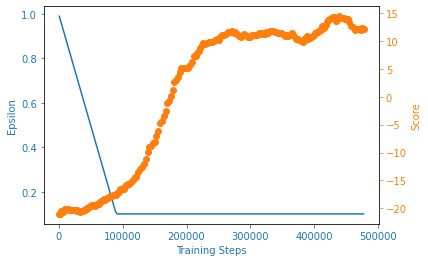

episode:  224 score:  11.0  average score 11.8 best score 11.92 epsilon 0.10 steps 479945


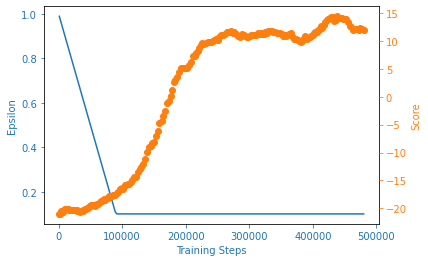

episode:  225 score:  14.0  average score 11.8 best score 11.92 epsilon 0.10 steps 482223


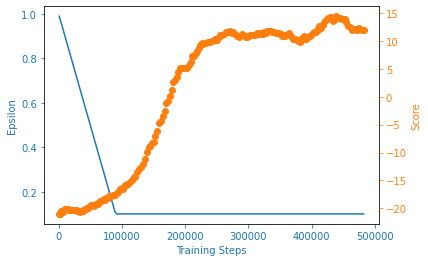

episode:  226 score:  11.0  average score 11.8 best score 11.92 epsilon 0.10 steps 484865


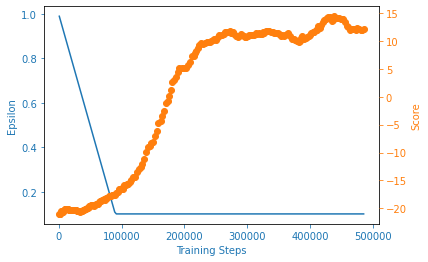

episode:  227 score:  9.0  average score 11.8 best score 11.92 epsilon 0.10 steps 487418


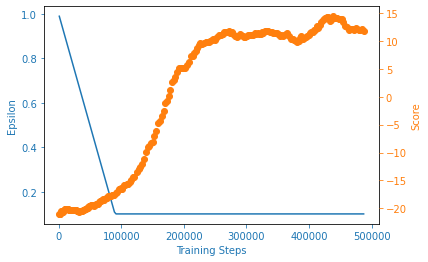

episode:  228 score:  12.0  average score 11.8 best score 11.92 epsilon 0.10 steps 489772


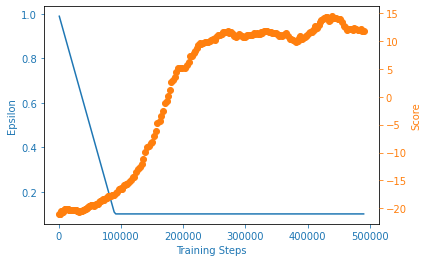

episode:  229 score:  15.0  average score 11.8 best score 11.92 epsilon 0.10 steps 492063


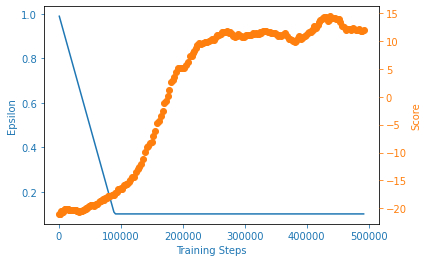

episode:  230 score:  17.0  average score 11.9 best score 11.92 epsilon 0.10 steps 494004


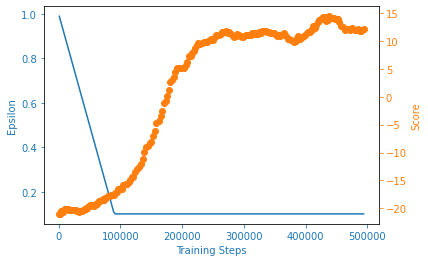

episode:  231 score:  9.0  average score 11.8 best score 11.92 epsilon 0.10 steps 496866


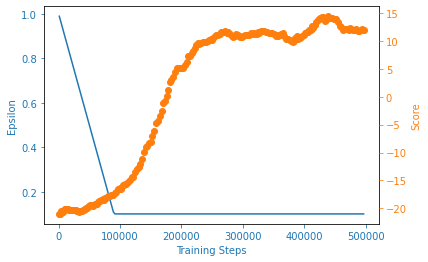

episode:  232 score:  19.0  average score 11.9 best score 11.92 epsilon 0.10 steps 498763


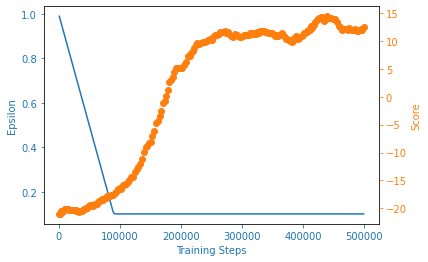

episode:  233 score:  16.0  average score 12.1 best score 11.92 epsilon 0.10 steps 500750
... saving checkpoint ...
... saving checkpoint ...


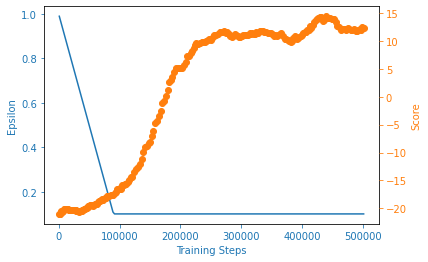

episode:  234 score:  13.0  average score 12.1 best score 12.06 epsilon 0.10 steps 502950
... saving checkpoint ...
... saving checkpoint ...


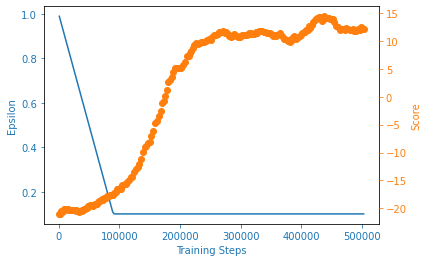

episode:  235 score:  15.0  average score 12.1 best score 12.11 epsilon 0.10 steps 505224


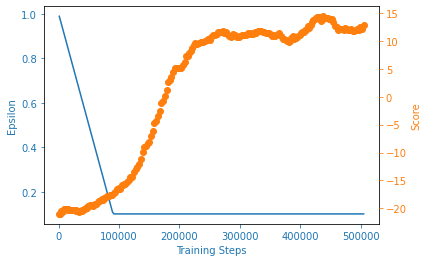

episode:  236 score:  18.0  average score 12.2 best score 12.11 epsilon 0.10 steps 507157
... saving checkpoint ...
... saving checkpoint ...


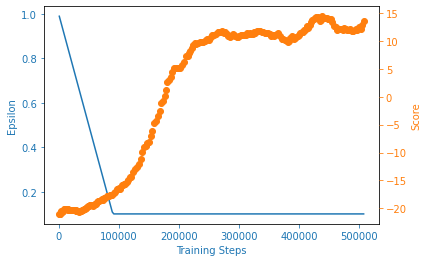

episode:  237 score:  17.0  average score 12.2 best score 12.17 epsilon 0.10 steps 509364
... saving checkpoint ...
... saving checkpoint ...


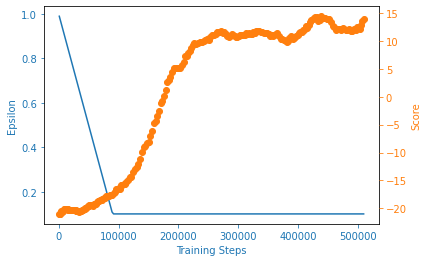

episode:  238 score:  13.0  average score 12.2 best score 12.23 epsilon 0.10 steps 511792


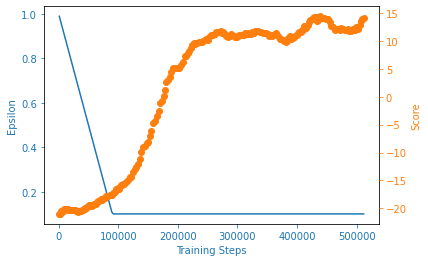

episode:  239 score:  16.0  average score 12.3 best score 12.23 epsilon 0.10 steps 513839
... saving checkpoint ...
... saving checkpoint ...


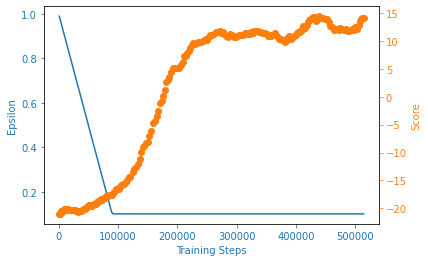

In [ ]:
env = make_env('PongNoFrameskip-v4')
best_score = -np.inf
load_checkpoint = False
n_games = 250

agent = DDQNAgent(gamma=0.99, epsilon=1, lr=0.0001,
                     input_dims=(env.observation_space.shape),
                     n_actions=env.action_space.n, mem_size=20000, eps_min=0.1,
                     batch_size=32, replace=1000, eps_dec=1e-5,
                     chkpt_dir='./', algo='DQNAgent',
                     env_name='PongNoFrameskip-v4')

if load_checkpoint:
    agent.load_models()

fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) + '_' + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'
# if you want to record video of your agent playing, do a mkdir tmp && mkdir tmp/dqn-video
# and uncomment the following 2 lines.
# env = wrappers.Monitor(env, "tmp/dqn-video",
#                    video_callable=lambda episode_id: True, force=True)
n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_
            n_steps += 1

    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode: ', i,'score: ', score,
        ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
        'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)

    x = [i+1 for i in range(len(scores))]
    plot_learning_curve(steps_array, scores, eps_history)